## Testing Mediapipe 

In [1]:
import mediapipe as mp # Import mediapipe
import cv2 # Import opencv

mp_drawing = mp.solutions.drawing_utils # Drawing helpers
mp_holistic = mp.solutions.holistic # Mediapipe Solutions

cap = cv2.VideoCapture(0)
# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False        
        
        # Make Detections
        results = holistic.process(image)

        # Recolor image back to BGR for rendering
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # 1. Draw face landmarks
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                 mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                 )
        
        # 2. Right hand
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )

        # 3. Left Hand
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )

        # 4. Pose Detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )
                        
        cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

## Export Keypoints and Lable to CSV file

### export train.csv

In [3]:
import mediapipe as mp
import cv2
import numpy as np
import csv
import os
import glob # For finding files with a pattern
import re

# --- Configuration ---
# Define your root dataset path. The script will automatically determine
# if it's 'Train' or 'Test' based on the directory name.
ROOT_DATASET_PATH = r"video dataset\Som PT\Train"

# Output CSV file names
TRAINING_CSV_NAME = 'TrainingVer0.csv'

# MediaPipe setup
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose # Using mp.solutions.pose as you're primarily concerned with pose

# --- CSV Header Generation ---
# This function will create the header row for your CSV
def get_csv_header():
    header = ['class_name', 'video_id', 'frame_num']
    for val in list(mp_pose.PoseLandmark):
        header += [f'{val.name.lower()}_x', f'{val.name.lower()}_y', f'{val.name.lower()}_z', f'{val.name.lower()}_visibility']
    return header

# --- Main Processing Function ---
def process_videos_in_folder(folder_path, output_csv_path):
    # Determine the class name from the folder path (e.g., 'Mix-Abduction')
    class_name = os.path.basename(folder_path).replace('-', '_').lower() # Converts 'Mix-Abduction' to 'mix_abduction'

    # Get all mp4 video files in the current folder
    video_files = glob.glob(os.path.join(folder_path, "*.mp4"))

    if not video_files:
        print(f"No .mp4 videos found in: {folder_path}")
        return

    # Check if the output CSV file exists and write header if not
    if not os.path.exists(output_csv_path) or os.path.getsize(output_csv_path) == 0:
        with open(output_csv_path, mode='w', newline='') as f:
            csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csv_writer.writerow(get_csv_header())
        print(f"Created/overwrote CSV file: {output_csv_path} with header.")

    # Initialize MediaPipe Pose detector
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose_detector:
        for video_path in video_files:
            full_video_name = os.path.splitext(os.path.basename(video_path))[0] # 'normal-202'
            match = re.search(r'(\d+)$', full_video_name)
            if match:
                video_id = match.group(1) # '202'
            else:
                # ถ้าหาไม่เจอตัวเลข ให้ใช้ชื่อเต็ม หรือแจ้งเตือน
                print(f"Warning: Could not extract numerical ID from {full_video_name}. Using full name as video_id.")
                video_id = full_video_name 

            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error: Could not open video {video_path}. Skipping.")
                continue

            frame_count = 0
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    # print(f"End of video or cannot read frame in {video_id}.")
                    break
                
                frame_count += 1

                # Recolor Feed
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image.flags.writeable = False # Improve performance
                
                # Make Detections
                results = pose_detector.process(image)
                
                # Export coordinates
                try:
                    # Extract Pose landmarks if detected
                    if results.pose_landmarks:
                        landmarks_data = results.pose_landmarks.landmark
                        # Flatten the landmarks into a single row
                        pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in landmarks_data]).flatten())
                    else:
                        # If no pose detected, fill with NaNs for all keypoint data
                        # This ensures the row length is consistent
                        pose_row = [np.nan] * (len(get_csv_header()) - 3) # -3 for class_name, video_id, frame_num

                    # Create the full row including class_name, video_id, and frame_num
                    full_row = [class_name, video_id, frame_count] + pose_row
                    
                    # Append to the output CSV
                    with open(output_csv_path, mode='a', newline='') as f:
                        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                        csv_writer.writerow(full_row) 
                except Exception as e: 
                    print(f"Error processing frame {frame_count} for video {video_id}: {e}")
                    pass # Continue to next frame even if an error occurs

            cap.release()
            print(f"Finished {full_video_name}. Total frames processed: {frame_count}")
    
    cv2.destroyAllWindows() # Ensures any open windows are closed

# --- Script Execution ---
if __name__ == "__main__":
    # Walk through the root dataset directory
    # os.walk generates (dirpath, dirnames, filenames)
    for dirpath, dirnames, filenames in os.walk(ROOT_DATASET_PATH):
        # We are looking for folders like 'Train' and 'Test' directly under ROOT_DATASET_PATH
        # or class-specific folders like 'Normal', 'Elbow_bent', etc.
        
        # Check if the current directory is a class subfolder (e.g., 'Normal', 'Elbow_bent')
        # We assume your structure is ROOT_DATASET_PATH -> (Train or Test) -> Class Folder
        
        # Determine the output CSV based on whether 'Train' or 'Test' is in the path
        output_csv_to_use = None
        if 'Train' in dirpath: # Assuming 'Train' is part of the path for training videos
            output_csv_to_use = TRAINING_CSV_NAME
        
        # This condition checks if we are in a class-specific folder that contains videos
        # And if it's under a 'Train' or 'Test' directory.
        # This prevents processing the root 'Som PT' folder directly if it contains videos.
        if output_csv_to_use and any(f.endswith('.mp4') for f in filenames):
            # Check if this is a direct class folder, not 'Train' or 'Test' parent itself
            # This is a bit of a heuristic. Adjust if your structure is different.
            if os.path.basename(dirpath).lower() not in ['train', 'test']:
                process_videos_in_folder(dirpath, output_csv_to_use)

    print("\n--- All video processing complete ---")
    print(f"Training data saved to: {TRAINING_CSV_NAME}")

Created/overwrote CSV file: TrainingVer0.csv with header.
Finished elbow_bent-202. Total frames processed: 1755


: 

### Export test.csv

In [ ]:
import mediapipe as mp
import cv2
import numpy as np
import csv
import os
import glob
import re

# --- Configuration ---
ROOT_DATASET_PATH = r"video dataset\Som PT\Test"
OUTPUT_CSV_PATH = 'testing_01.csv'

# MediaPipe setup
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# --- CSV Header Generation ---
def get_csv_header():
    header = ['class_name', 'video_id', 'frame_num']
    for val in list(mp_pose.PoseLandmark):
        header += [f'{val.name.lower()}_x', f'{val.name.lower()}_y', f'{val.name.lower()}_z', f'{val.name.lower()}_visibility']
    return header

# --- Main Processing ---
def process_flat_video_folder(folder_path, output_csv_path):
    video_files = glob.glob(os.path.join(folder_path, "*.mp4"))
    if not video_files:
        print(f"No .mp4 videos found in: {folder_path}")
        return

    # Write header if file does not exist
    if not os.path.exists(output_csv_path) or os.path.getsize(output_csv_path) == 0:
        with open(output_csv_path, mode='w', newline='') as f:
            csv_writer = csv.writer(f)
            csv_writer.writerow(get_csv_header())
        print(f"Created CSV file: {output_csv_path}")

    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose_detector:
        for video_path in video_files:
            file_name = os.path.splitext(os.path.basename(video_path))[0]
            
            # 🔸 Extract class name from file name (e.g., "normal-01" -> "normal")
            class_match = re.match(r"([a-zA-Z_]+)", file_name)
            class_name = class_match.group(1).lower() if class_match else "unknown"

            # 🔸 Extract numerical ID (e.g., "normal-01" -> "01")
            id_match = re.search(r"(\d+)", file_name)
            video_id = id_match.group(1) if id_match else file_name

            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error: Could not open video {video_path}")
                continue

            frame_count = 0
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                frame_count += 1
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image.flags.writeable = False

                results = pose_detector.process(image)

                try:
                    if results.pose_landmarks:
                        landmarks = results.pose_landmarks.landmark
                        pose_row = list(np.array([[lm.x, lm.y, lm.z, lm.visibility] for lm in landmarks]).flatten())
                    else:
                        pose_row = [np.nan] * (len(get_csv_header()) - 3)

                    full_row = [class_name, video_id, frame_count] + pose_row

                    with open(output_csv_path, mode='a', newline='') as f:
                        csv_writer = csv.writer(f)
                        csv_writer.writerow(full_row)

                except Exception as e:
                    print(f"Error in frame {frame_count}, video {video_path}: {e}")
                    continue

            cap.release()
            print(f"✅ Processed: {file_name} ({frame_count} frames)")

    cv2.destroyAllWindows()
    print("\n--- All videos processed ---")

# --- Run ---
if __name__ == "__main__":
    process_flat_video_folder(ROOT_DATASET_PATH, OUTPUT_CSV_PATH)


### Export validate.csv

In [1]:
import mediapipe as mp
import cv2
import numpy as np
import csv
import os
import glob
import re

# --- Configuration ---
ROOT_DATASET_PATH = r"video dataset\Som PT\Val"
OUTPUT_CSV_PATH = 'validate_01.csv'

# MediaPipe setup
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# --- CSV Header Generation ---
def get_csv_header():
    header = ['class_name', 'video_id', 'frame_num']
    for val in list(mp_pose.PoseLandmark):
        header += [f'{val.name.lower()}_x', f'{val.name.lower()}_y', f'{val.name.lower()}_z', f'{val.name.lower()}_visibility']
    return header

# --- Main Processing ---
def process_flat_video_folder(folder_path, output_csv_path):
    video_files = glob.glob(os.path.join(folder_path, "*.mp4"))
    if not video_files:
        print(f"No .mp4 videos found in: {folder_path}")
        return

    # Write header if file does not exist
    if not os.path.exists(output_csv_path) or os.path.getsize(output_csv_path) == 0:
        with open(output_csv_path, mode='w', newline='') as f:
            csv_writer = csv.writer(f)
            csv_writer.writerow(get_csv_header())
        print(f"Created CSV file: {output_csv_path}")

    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose_detector:
        for video_path in video_files:
            file_name = os.path.splitext(os.path.basename(video_path))[0]
            
            # 🔸 Extract class name from file name (e.g., "normal-01" -> "normal")
            class_match = re.match(r"([a-zA-Z_]+)", file_name)
            class_name = class_match.group(1).lower() if class_match else "unknown"

            # 🔸 Extract numerical ID (e.g., "normal-01" -> "01")
            id_match = re.search(r"(\d+)", file_name)
            video_id = id_match.group(1) if id_match else file_name

            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error: Could not open video {video_path}")
                continue

            frame_count = 0
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                frame_count += 1
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image.flags.writeable = False

                results = pose_detector.process(image)

                try:
                    if results.pose_landmarks:
                        landmarks = results.pose_landmarks.landmark
                        pose_row = list(np.array([[lm.x, lm.y, lm.z, lm.visibility] for lm in landmarks]).flatten())
                    else:
                        pose_row = [np.nan] * (len(get_csv_header()) - 3)

                    full_row = [class_name, video_id, frame_count] + pose_row

                    with open(output_csv_path, mode='a', newline='') as f:
                        csv_writer = csv.writer(f)
                        csv_writer.writerow(full_row)

                except Exception as e:
                    print(f"Error in frame {frame_count}, video {video_path}: {e}")
                    continue

            cap.release()
            print(f"✅ Processed: {file_name} ({frame_count} frames)")

    cv2.destroyAllWindows()
    print("\n--- All videos processed ---")

# --- Run ---
if __name__ == "__main__":
    process_flat_video_folder(ROOT_DATASET_PATH, OUTPUT_CSV_PATH)


Created CSV file: validate_01.csv
✅ Processed: elbow_bent ultra cut-1 (4058 frames)
✅ Processed: mix_ab ultra cut-1 (3659 frames)
✅ Processed: neck_tlit ultra cut-1 (3424 frames)
✅ Processed: tremor ultra cut-1 (4193 frames)
✅ Processed: trunk_twist ultra cut-1 (3446 frames)

--- All videos processed ---


#### I forgot to add normal in folder so this repeat is for export normal keypoint

In [3]:
import mediapipe as mp
import cv2
import numpy as np
import csv
import os
import glob
import re

# --- Configuration ---
ROOT_DATASET_PATH = r"D:\I'm a doctor\AI PT Coach\video dataset\Som PT\Val\nnnn"
OUTPUT_CSV_PATH = 'validate_01.csv'

# MediaPipe setup
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# --- CSV Header Generation ---
def get_csv_header():
    header = ['class_name', 'video_id', 'frame_num']
    for val in list(mp_pose.PoseLandmark):
        header += [f'{val.name.lower()}_x', f'{val.name.lower()}_y', f'{val.name.lower()}_z', f'{val.name.lower()}_visibility']
    return header

# --- Main Processing ---
def process_flat_video_folder(folder_path, output_csv_path):
    video_files = glob.glob(os.path.join(folder_path, "*.mp4"))
    if not video_files:
        print(f"No .mp4 videos found in: {folder_path}")
        return

    # Write header if file does not exist
    if not os.path.exists(output_csv_path) or os.path.getsize(output_csv_path) == 0:
        with open(output_csv_path, mode='w', newline='') as f:
            csv_writer = csv.writer(f)
            csv_writer.writerow(get_csv_header())
        print(f"Created CSV file: {output_csv_path}")

    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose_detector:
        for video_path in video_files:
            file_name = os.path.splitext(os.path.basename(video_path))[0]
            
            # 🔸 Extract class name from file name (e.g., "normal-01" -> "normal")
            class_match = re.match(r"([a-zA-Z_]+)", file_name)
            class_name = class_match.group(1).lower() if class_match else "unknown"

            # 🔸 Extract numerical ID (e.g., "normal-01" -> "01")
            id_match = re.search(r"(\d+)", file_name)
            video_id = id_match.group(1) if id_match else file_name

            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error: Could not open video {video_path}")
                continue

            frame_count = 0
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                frame_count += 1
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image.flags.writeable = False

                results = pose_detector.process(image)

                try:
                    if results.pose_landmarks:
                        landmarks = results.pose_landmarks.landmark
                        pose_row = list(np.array([[lm.x, lm.y, lm.z, lm.visibility] for lm in landmarks]).flatten())
                    else:
                        pose_row = [np.nan] * (len(get_csv_header()) - 3)

                    full_row = [class_name, video_id, frame_count] + pose_row

                    with open(output_csv_path, mode='a', newline='') as f:
                        csv_writer = csv.writer(f)
                        csv_writer.writerow(full_row)

                except Exception as e:
                    print(f"Error in frame {frame_count}, video {video_path}: {e}")
                    continue

            cap.release()
            print(f"✅ Processed: {file_name} ({frame_count} frames)")

    cv2.destroyAllWindows()
    print("\n--- All videos processed ---")

# --- Run ---
if __name__ == "__main__":
    process_flat_video_folder(ROOT_DATASET_PATH, OUTPUT_CSV_PATH)


✅ Processed: normal ultra cut-1 (2556 frames)

--- All videos processed ---


## Explore Data

In [2]:
import pandas as pd
import numpy as np
import mediapipe as mp # For landmark definitions (helpful for column names)

# Load your CSVs
train_df = pd.read_csv('training_01.csv')
test_df = pd.read_csv('testing_01.csv')
validate_df = pd.read_csv('validate_01.csv')

In [14]:
validate_df.head(10)

,class_name,video_id,frame_num,nose_x,nose_y,nose_z,nose_visibility,left_eye_inner_x,left_eye_inner_y,left_eye_inner_z,...,right_heel_z,right_heel_visibility,left_foot_index_x,left_foot_index_y,left_foot_index_z,left_foot_index_visibility,right_foot_index_x,right_foot_index_y,right_foot_index_z,right_foot_index_visibility
0,elbow_bent,1,1,0.574129,0.593075,-0.138845,0.997667,0.590834,0.600818,-0.167683,...,0.326768,0.032167,-0.172920,0.686360,-0.011570,0.170885,-0.133613,0.644943,0.240015,0.030211
1,elbow_bent,1,2,0.571512,0.589623,-0.129267,0.997438,0.589780,0.599679,-0.157033,...,0.307103,0.031119,-0.170373,0.686622,0.004210,0.163626,-0.133608,0.644816,0.228532,0.028504
2,elbow_bent,1,3,0.569905,0.588555,-0.131824,0.997223,0.589006,0.599479,-0.158178,...,0.305753,0.031370,-0.154204,0.687101,0.023426,0.161962,-0.118646,0.649377,0.229432,0.027840
3,elbow_bent,1,4,0.568794,0.587679,-0.130937,0.997021,0.588238,0.599176,-0.157589,...,0.298104,0.030817,-0.155834,0.691179,0.016668,0.157632,-0.120552,0.653468,0.221981,0.026785
4,elbow_bent,1,5,0.568306,0.587158,-0.126668,0.996889,0.587878,0.598934,-0.153325,...,0.298289,0.030349,-0.155559,0.695468,0.022135,0.153500,-0.121839,0.653971,0.221365,0.025833
5,elbow_bent,1,6,0.567979,0.586838,-0.127316,0.996702,0.587645,0.598750,-0.154053,...,0.298682,0.030161,-0.150243,0.696715,0.036684,0.150536,-0.119246,0.655627,0.230344,0.025101
6,elbow_bent,1,7,0.567580,0.586520,-0.130759,0.996601,0.587307,0.598463,-0.156842,...,0.301039,0.030166,-0.148756,0.699720,0.034138,0.149806,-0.118669,0.658803,0.231722,0.024734
7,elbow_bent,1,8,0.567175,0.586539,-0.125519,0.996450,0.586907,0.598460,-0.152026,...,0.301755,0.029204,-0.149355,0.701244,0.028998,0.145030,-0.122911,0.658760,0.227308,0.023652
8,elbow_bent,1,9,0.566719,0.586595,-0.126526,0.996265,0.586427,0.598506,-0.152675,...,0.303021,0.029190,-0.149408,0.705224,0.033027,0.144778,-0.121969,0.661428,0.228051,0.023406
9,elbow_bent,1,10,0.566279,0.586613,-0.123731,0.996085,0.586016,0.598503,-0.150148,...,0.305647,0.028482,-0.150147,0.712600,0.033469,0.140610,-0.121488,0.665229,0.236881,0.022520


In [15]:
print(train_df.shape)
print(test_df.shape)
print(validate_df.shape)

(42647, 135)
(10698, 135)
(21379, 135)


In [18]:
validate_df.isnull().sum()

class_name                     0
video_id                       0
frame_num                      0
nose_x                         0
nose_y                         0
                              ..
left_foot_index_visibility     0
right_foot_index_x             0
right_foot_index_y             0
right_foot_index_z             0
right_foot_index_visibility    0
Length: 135, dtype: int64

## Doing training 4 experiment to find which method got highest performance
### 1.training with raw keypoints


🔵 Training model: lr
✅ Train Accuracy: 0.9966
               precision    recall  f1-score   support

   elbow_bent       1.00      1.00      1.00      7310
mix_abduction       0.99      0.99      0.99      7121
    neck_tilt       1.00      1.00      1.00      5850
       normal       0.99      0.99      0.99      8186
       tremor       1.00      1.00      1.00      8545
  trunk_twist       1.00      1.00      1.00      5635

     accuracy                           1.00     42647
    macro avg       1.00      1.00      1.00     42647
 weighted avg       1.00      1.00      1.00     42647



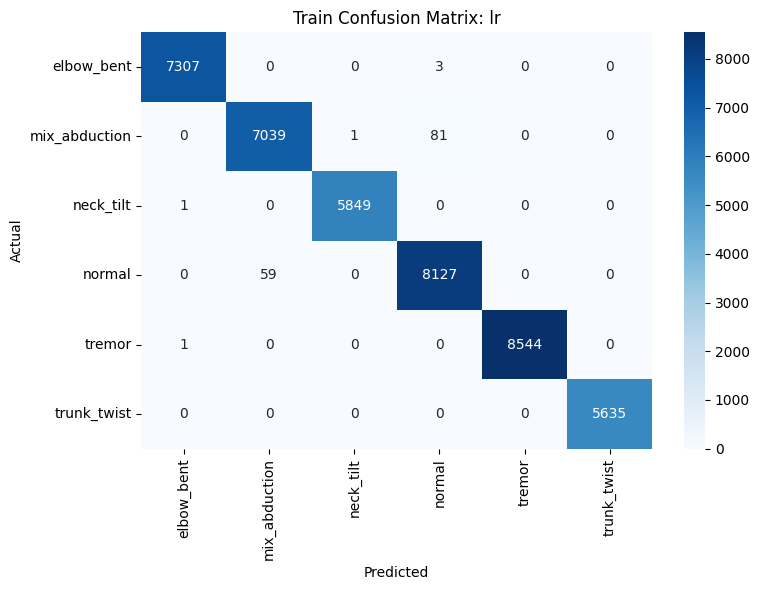

✅ Test Accuracy: 0.9550
               precision    recall  f1-score   support

   elbow_bent       0.97      0.96      0.96      1768
mix_abduction       1.00      0.94      0.97      1901
    neck_tilt       0.84      0.99      0.91      1617
       normal       0.95      0.96      0.96      2079
       tremor       1.00      1.00      1.00      1973
  trunk_twist       0.99      0.85      0.92      1360

     accuracy                           0.96     10698
    macro avg       0.96      0.95      0.95     10698
 weighted avg       0.96      0.96      0.96     10698



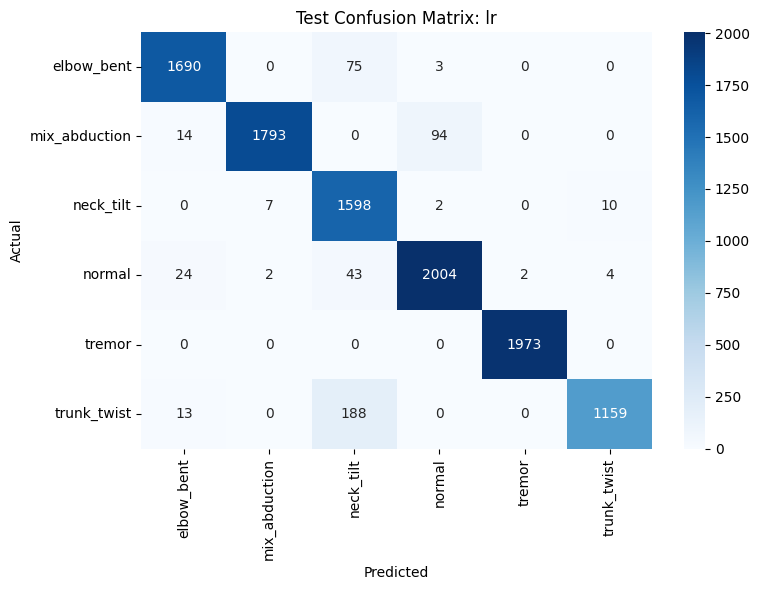

✅ Validation Accuracy: 0.2067


d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

  elbow_bent       0.23      0.02      0.04      4058
      mix_ab       0.00      0.00      0.00      3659
   neck_tlit       0.00      0.00      0.00      3424
      normal       0.00      0.00      0.00      2599
      tremor       0.20      1.00      0.34      4193
 trunk_twist       0.87      0.04      0.07      3446

    accuracy                           0.21     21379
   macro avg       0.22      0.18      0.08     21379
weighted avg       0.22      0.21      0.09     21379



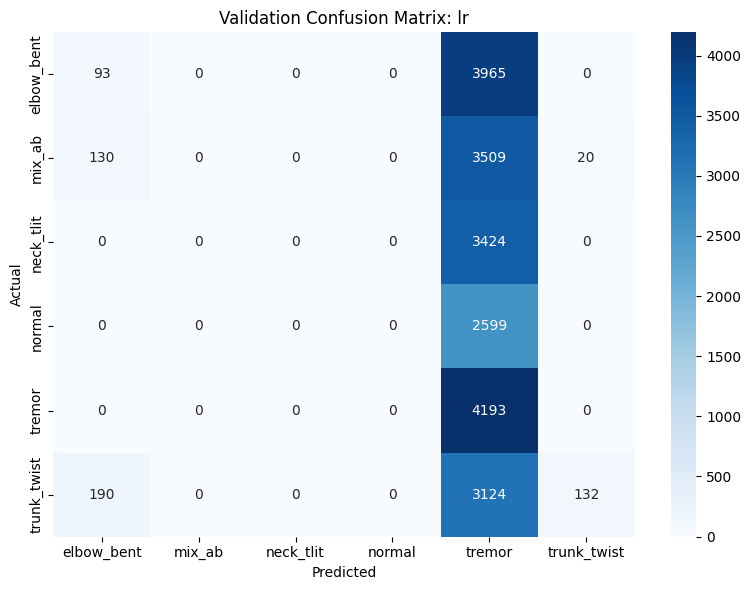


🔵 Training model: rc
✅ Train Accuracy: 0.9759
               precision    recall  f1-score   support

   elbow_bent       0.99      1.00      1.00      7310
mix_abduction       0.93      0.95      0.94      7121
    neck_tilt       0.99      0.99      0.99      5850
       normal       0.95      0.93      0.94      8186
       tremor       1.00      1.00      1.00      8545
  trunk_twist       1.00      0.99      0.99      5635

     accuracy                           0.98     42647
    macro avg       0.98      0.98      0.98     42647
 weighted avg       0.98      0.98      0.98     42647



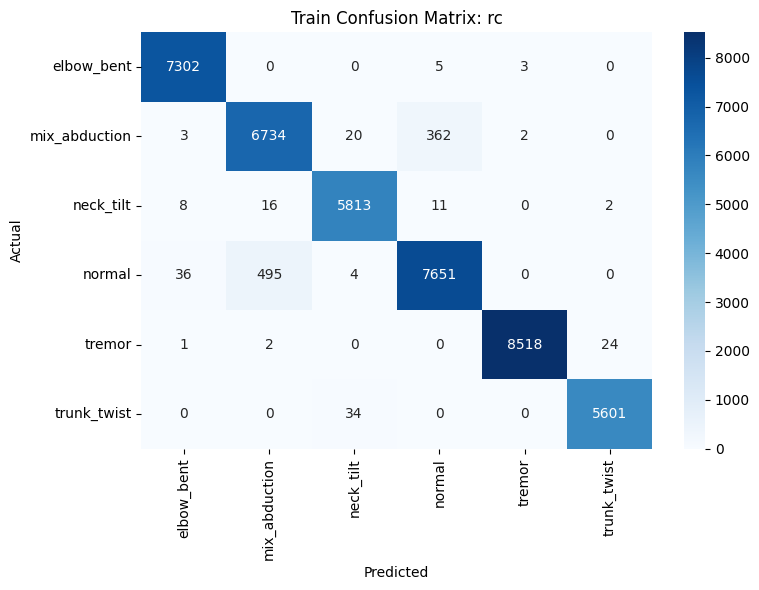

✅ Test Accuracy: 0.9281
               precision    recall  f1-score   support

   elbow_bent       0.94      0.98      0.96      1768
mix_abduction       0.99      0.78      0.87      1901
    neck_tilt       0.89      0.99      0.94      1617
       normal       0.82      0.91      0.86      2079
       tremor       1.00      1.00      1.00      1973
  trunk_twist       1.00      0.92      0.96      1360

     accuracy                           0.93     10698
    macro avg       0.94      0.93      0.93     10698
 weighted avg       0.93      0.93      0.93     10698



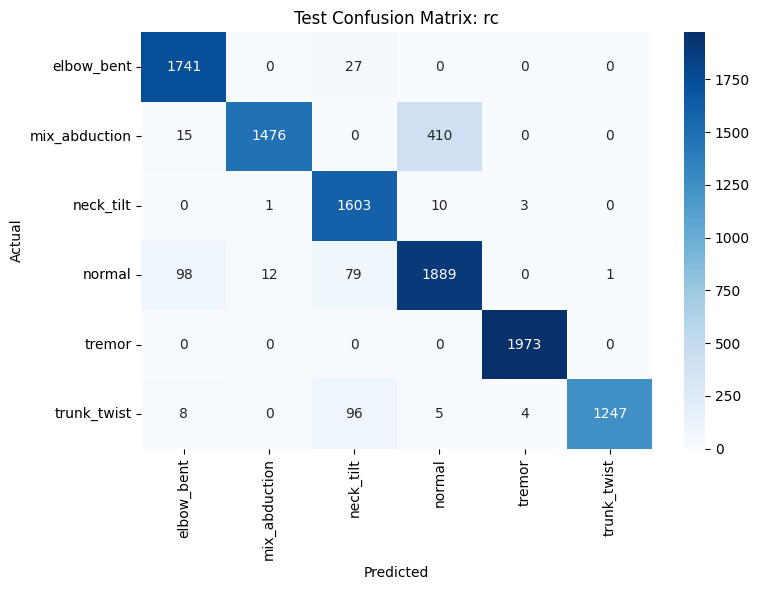

✅ Validation Accuracy: 0.2367


d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\I'm a doc

               precision    recall  f1-score   support

   elbow_bent       0.06      0.00      0.00      4058
       mix_ab       0.00      0.00      0.00      3659
mix_abduction       0.00      0.00      0.00         0
    neck_tilt       0.00      0.00      0.00         0
    neck_tlit       0.00      0.00      0.00      3424
       normal       0.00      0.00      0.00      2599
       tremor       0.20      0.95      0.34      4193
  trunk_twist       0.73      0.31      0.43      3446

     accuracy                           0.24     21379
    macro avg       0.12      0.16      0.10     21379
 weighted avg       0.17      0.24      0.14     21379



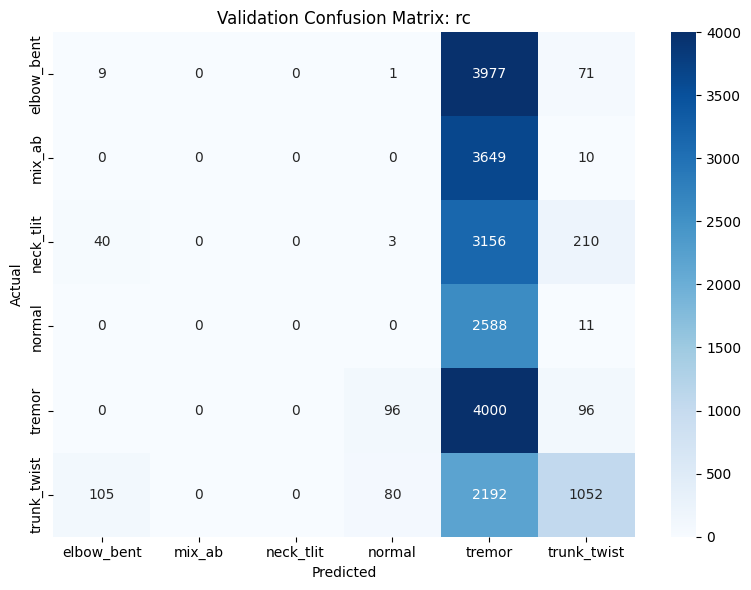


🔵 Training model: rf
✅ Train Accuracy: 1.0000
               precision    recall  f1-score   support

   elbow_bent       1.00      1.00      1.00      7310
mix_abduction       1.00      1.00      1.00      7121
    neck_tilt       1.00      1.00      1.00      5850
       normal       1.00      1.00      1.00      8186
       tremor       1.00      1.00      1.00      8545
  trunk_twist       1.00      1.00      1.00      5635

     accuracy                           1.00     42647
    macro avg       1.00      1.00      1.00     42647
 weighted avg       1.00      1.00      1.00     42647



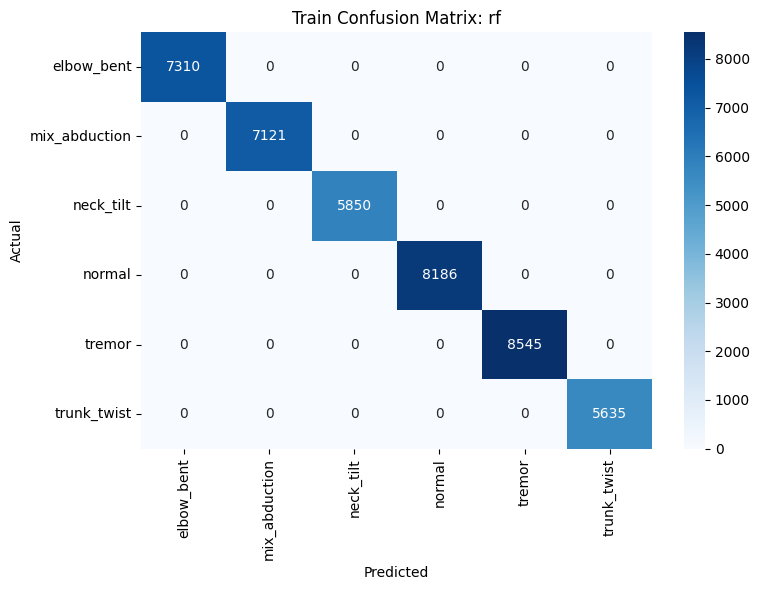

✅ Test Accuracy: 0.9562
               precision    recall  f1-score   support

   elbow_bent       1.00      0.97      0.99      1768
mix_abduction       0.98      0.92      0.95      1901
    neck_tilt       0.88      0.99      0.93      1617
       normal       0.90      0.98      0.94      2079
       tremor       1.00      1.00      1.00      1973
  trunk_twist       1.00      0.86      0.93      1360

     accuracy                           0.96     10698
    macro avg       0.96      0.95      0.95     10698
 weighted avg       0.96      0.96      0.96     10698



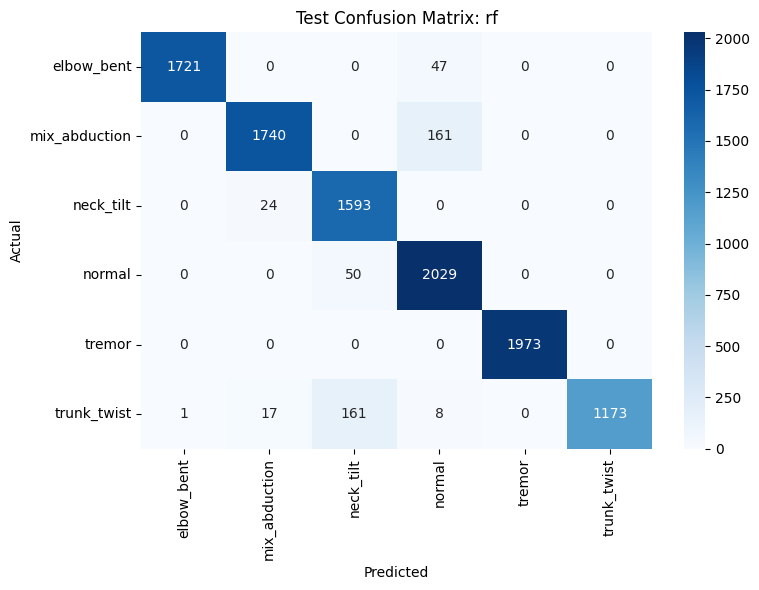

✅ Validation Accuracy: 0.1920


d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\I'm a doc

              precision    recall  f1-score   support

  elbow_bent       0.03      0.00      0.00      4058
      mix_ab       0.00      0.00      0.00      3659
   neck_tilt       0.00      0.00      0.00         0
   neck_tlit       0.00      0.00      0.00      3424
      normal       0.00      0.00      0.00      2599
      tremor       0.21      0.98      0.35      4193
 trunk_twist       0.00      0.00      0.00      3446

    accuracy                           0.19     21379
   macro avg       0.03      0.14      0.05     21379
weighted avg       0.05      0.19      0.07     21379



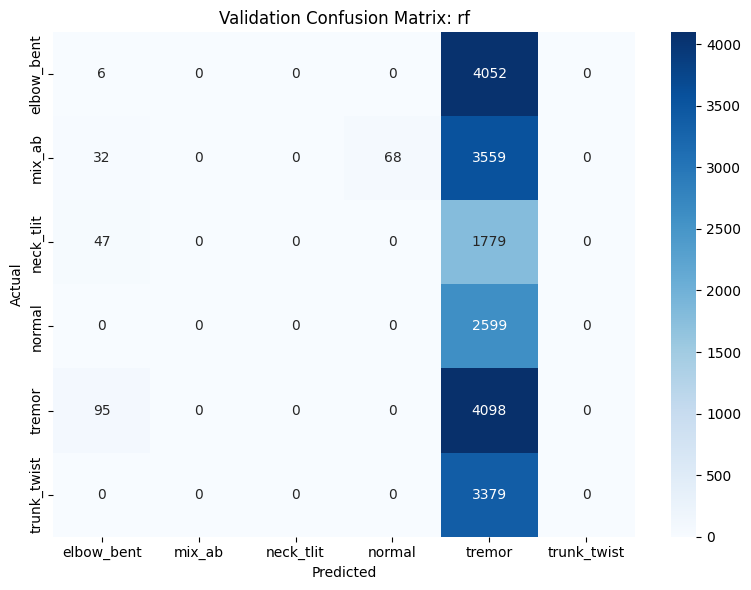

In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load Datasets ---
train_df = pd.read_csv(r'training_01.csv').dropna()
test_df = pd.read_csv(r'testing_01.csv').dropna()
val_df = pd.read_csv(r'validate_01.csv').dropna()  # 🔸 วิดีโอคนใหม่ มุมใหม่

# --- Split features & labels ---
def prepare_xy(df):
    X = df.drop(columns=['class_name', 'video_id', 'frame_num'])
    y = df['class_name']
    return X, y

X_train, y_train = prepare_xy(train_df)
X_test, y_test = prepare_xy(test_df)
X_val, y_val = prepare_xy(val_df)

# --- Define Model Pipelines ---
pipelines = {
    'lr': make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    'rc': make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier()),
}

# --- Train + Evaluate All Sets ---
fit_models = {}
for name, model in pipelines.items():
    print(f"\n🔵 Training model: {name}")
    model.fit(X_train, y_train)
    fit_models[name] = model

    for split_name, X, y in [
        ('Train', X_train, y_train),
        ('Test', X_test, y_test),
        ('Validation', X_val, y_val),
    ]:
        y_pred = model.predict(X)
        acc = accuracy_score(y, y_pred)
        print(f"✅ {split_name} Accuracy: {acc:.4f}")
        print(classification_report(y, y_pred))

        # --- Confusion Matrix ---
        labels = np.unique(y)
        cm = confusion_matrix(y, y_pred, labels=labels)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels)
        plt.title(f'{split_name} Confusion Matrix: {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()


#####  จากการเทรนเมื่อกี้มีปัญหา ill-defined คือโมเดลไม่สามารถทำนายออกมาได้ว่าคลาสไหน ผมคิดว่าเป็นเพราะtremor นั้นเป็นท่าที่สามารถดู frame by frame ได้ยากจึงจะลองตัด tremor ทิ้ง
##### Solve overfitting and ill-defined

In [3]:
# ลบ tremor ออกจาก train และ test
train_df = train_df[train_df['class_name'] != 'tremor']
test_df = test_df[test_df['class_name'] != 'tremor']
validate_df = validate_df[validate_df['class_name'] != 'tremor']

In [ ]:
#พบว่าชื่อ class ไม่ตรงกัน
print(train_df['class_name'].unique())
print(test_df['class_name'].unique())
print(validate_df['class_name'].unique())

['elbow_bent' 'mix_abduction' 'neck_tilt' 'normal' 'trunk_twist']
['elbow_bent' 'mix_abduction' 'neck_tilt' 'normal' 'trunk_twist']
['elbow_bent' 'mix_ab' 'neck_tlit' 'trunk_twist' 'normal']


In [14]:
validate_df['class_name'] = validate_df['class_name'].replace({
    'mix_ab': 'mix_abduction',
    'neck_tlit': 'neck_tilt'
})
print(validate_df['class_name'].unique())

['elbow_bent' 'mix_abduction' 'neck_tilt' 'trunk_twist' 'normal']


In [15]:
print(train_df['class_name'].unique())
print(test_df['class_name'].unique())
print(validate_df['class_name'].unique())

['elbow_bent' 'mix_abduction' 'neck_tilt' 'normal' 'trunk_twist']
['elbow_bent' 'mix_abduction' 'neck_tilt' 'normal' 'trunk_twist']
['elbow_bent' 'mix_abduction' 'neck_tilt' 'trunk_twist' 'normal']



🔵 Training model: lr
✅ Train Accuracy: 0.9966
               precision    recall  f1-score   support

   elbow_bent       1.00      1.00      1.00      7310
mix_abduction       0.99      0.99      0.99      7121
    neck_tilt       1.00      1.00      1.00      5850
       normal       0.99      0.99      0.99      8186
       tremor       1.00      1.00      1.00      8545
  trunk_twist       1.00      1.00      1.00      5635

     accuracy                           1.00     42647
    macro avg       1.00      1.00      1.00     42647
 weighted avg       1.00      1.00      1.00     42647



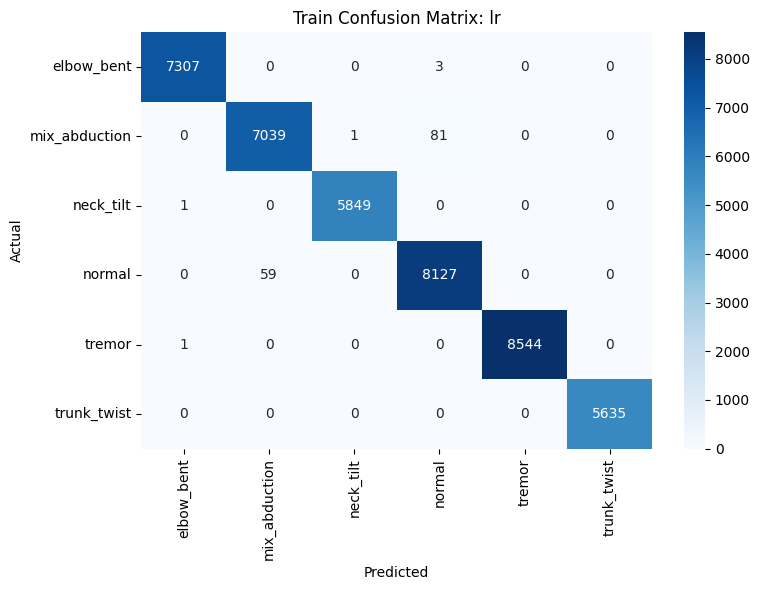

✅ Test Accuracy: 0.9550
               precision    recall  f1-score   support

   elbow_bent       0.97      0.96      0.96      1768
mix_abduction       1.00      0.94      0.97      1901
    neck_tilt       0.84      0.99      0.91      1617
       normal       0.95      0.96      0.96      2079
       tremor       1.00      1.00      1.00      1973
  trunk_twist       0.99      0.85      0.92      1360

     accuracy                           0.96     10698
    macro avg       0.96      0.95      0.95     10698
 weighted avg       0.96      0.96      0.96     10698



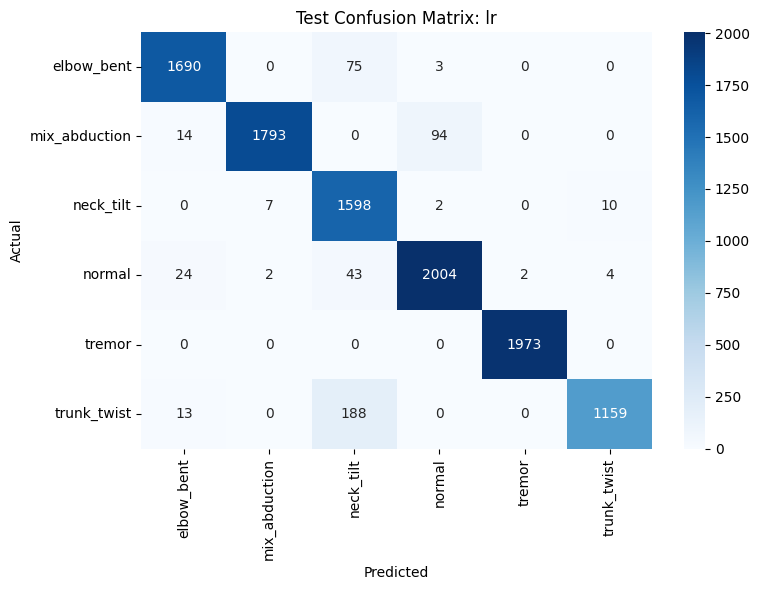

✅ Validation Accuracy: 0.2067
               precision    recall  f1-score   support

   elbow_bent       0.23      0.02      0.04      4058
mix_abduction       0.00      0.00      0.00      3659
    neck_tilt       0.00      0.00      0.00      3424
       normal       0.00      0.00      0.00      2599
       tremor       0.20      1.00      0.34      4193
  trunk_twist       0.87      0.04      0.07      3446

     accuracy                           0.21     21379
    macro avg       0.22      0.18      0.08     21379
 weighted avg       0.22      0.21      0.09     21379



d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


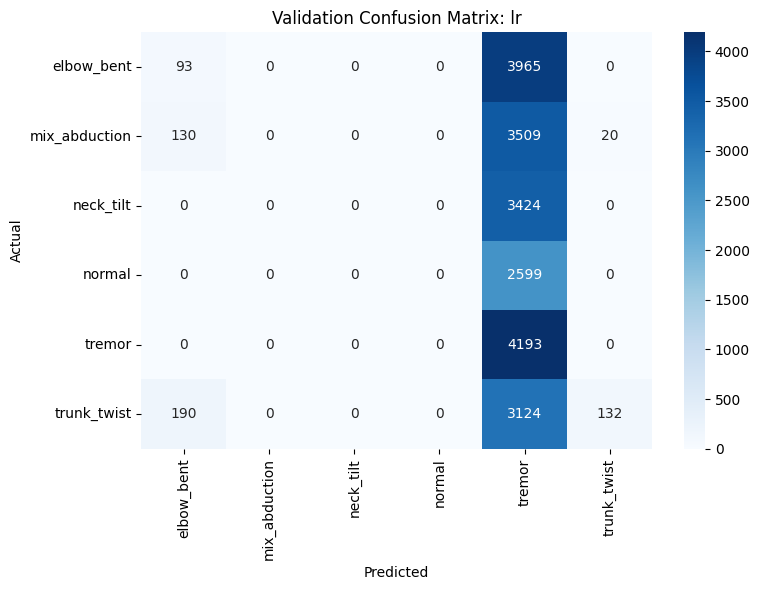


🔵 Training model: rc
✅ Train Accuracy: 0.9759
               precision    recall  f1-score   support

   elbow_bent       0.99      1.00      1.00      7310
mix_abduction       0.93      0.95      0.94      7121
    neck_tilt       0.99      0.99      0.99      5850
       normal       0.95      0.93      0.94      8186
       tremor       1.00      1.00      1.00      8545
  trunk_twist       1.00      0.99      0.99      5635

     accuracy                           0.98     42647
    macro avg       0.98      0.98      0.98     42647
 weighted avg       0.98      0.98      0.98     42647



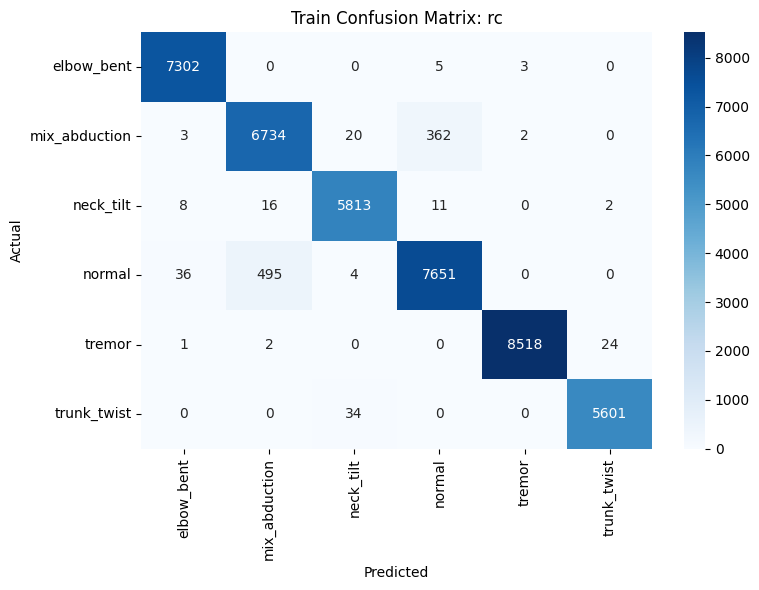

✅ Test Accuracy: 0.9281
               precision    recall  f1-score   support

   elbow_bent       0.94      0.98      0.96      1768
mix_abduction       0.99      0.78      0.87      1901
    neck_tilt       0.89      0.99      0.94      1617
       normal       0.82      0.91      0.86      2079
       tremor       1.00      1.00      1.00      1973
  trunk_twist       1.00      0.92      0.96      1360

     accuracy                           0.93     10698
    macro avg       0.94      0.93      0.93     10698
 weighted avg       0.93      0.93      0.93     10698



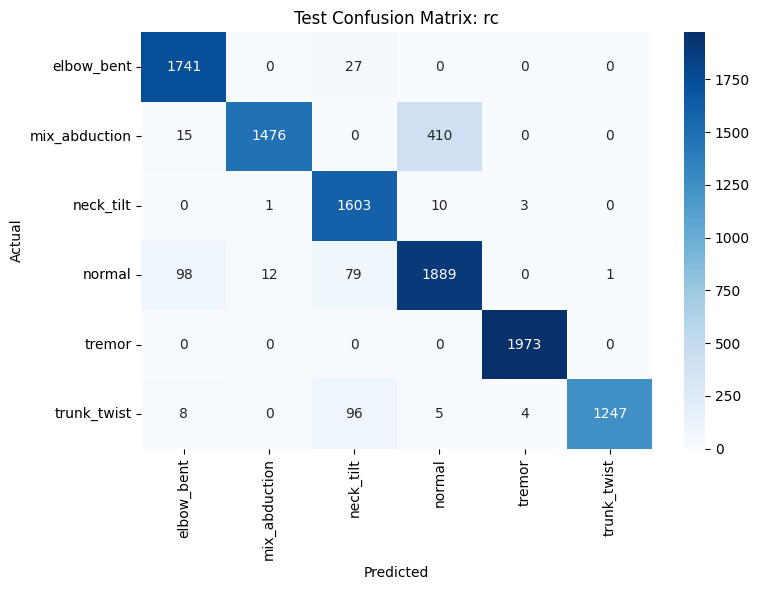

✅ Validation Accuracy: 0.2370
               precision    recall  f1-score   support

   elbow_bent       0.06      0.00      0.00      4058
mix_abduction       0.00      0.00      0.00      3659
    neck_tilt       0.83      0.00      0.00      3424
       normal       0.00      0.00      0.00      2599
       tremor       0.20      0.95      0.34      4193
  trunk_twist       0.73      0.31      0.43      3446

     accuracy                           0.24     21379
    macro avg       0.30      0.21      0.13     21379
 weighted avg       0.30      0.24      0.14     21379



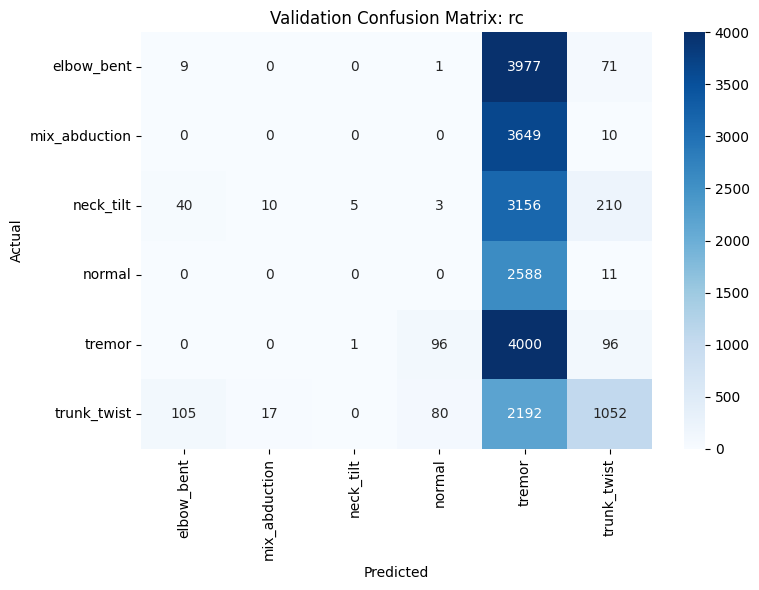


🔵 Training model: rf
✅ Train Accuracy: 1.0000
               precision    recall  f1-score   support

   elbow_bent       1.00      1.00      1.00      7310
mix_abduction       1.00      1.00      1.00      7121
    neck_tilt       1.00      1.00      1.00      5850
       normal       1.00      1.00      1.00      8186
       tremor       1.00      1.00      1.00      8545
  trunk_twist       1.00      1.00      1.00      5635

     accuracy                           1.00     42647
    macro avg       1.00      1.00      1.00     42647
 weighted avg       1.00      1.00      1.00     42647



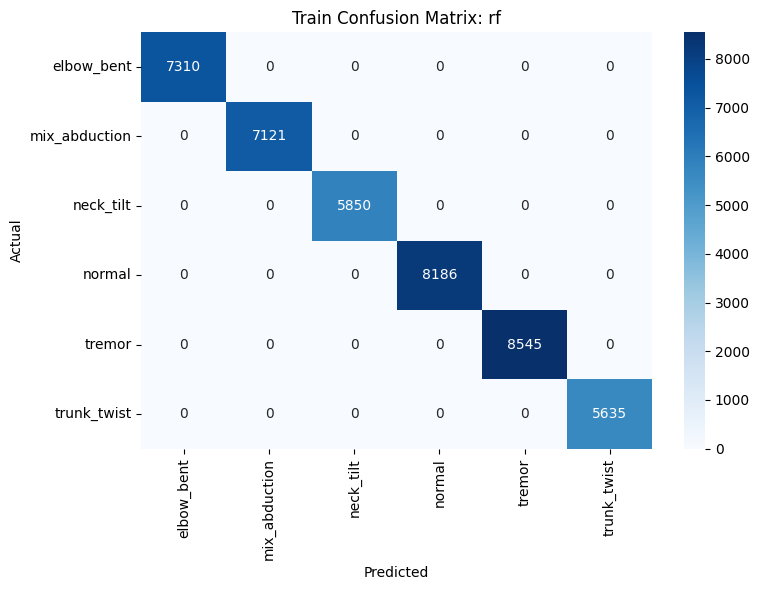

✅ Test Accuracy: 0.9541
               precision    recall  f1-score   support

   elbow_bent       1.00      0.98      0.99      1768
mix_abduction       0.97      0.92      0.95      1901
    neck_tilt       0.87      0.99      0.92      1617
       normal       0.91      0.97      0.94      2079
       tremor       1.00      1.00      1.00      1973
  trunk_twist       1.00      0.84      0.91      1360

     accuracy                           0.95     10698
    macro avg       0.96      0.95      0.95     10698
 weighted avg       0.96      0.95      0.95     10698



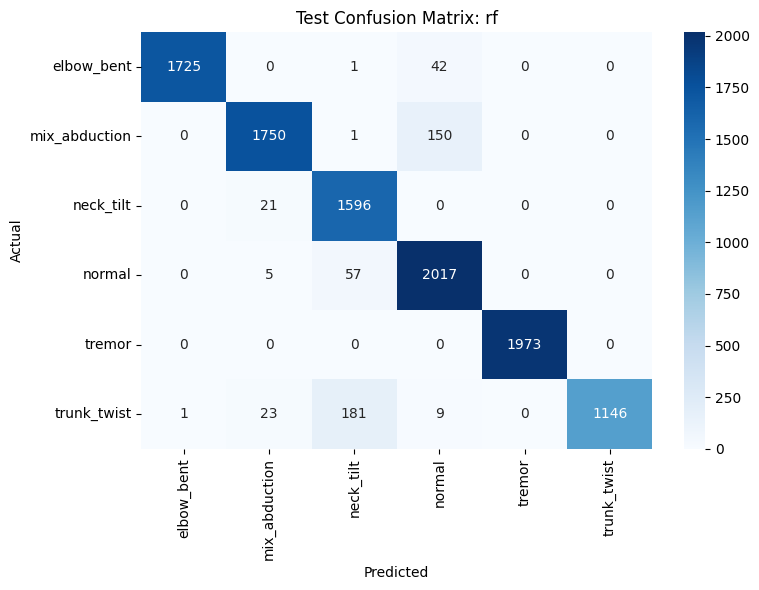

✅ Validation Accuracy: 0.2610
               precision    recall  f1-score   support

   elbow_bent       0.01      0.00      0.00      4058
mix_abduction       0.00      0.00      0.00      3659
    neck_tilt       0.96      0.46      0.62      3424
       normal       0.00      0.00      0.00      2599
       tremor       0.21      0.95      0.34      4193
  trunk_twist       0.00      0.00      0.00      3446

     accuracy                           0.26     21379
    macro avg       0.20      0.24      0.16     21379
 weighted avg       0.20      0.26      0.17     21379



d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


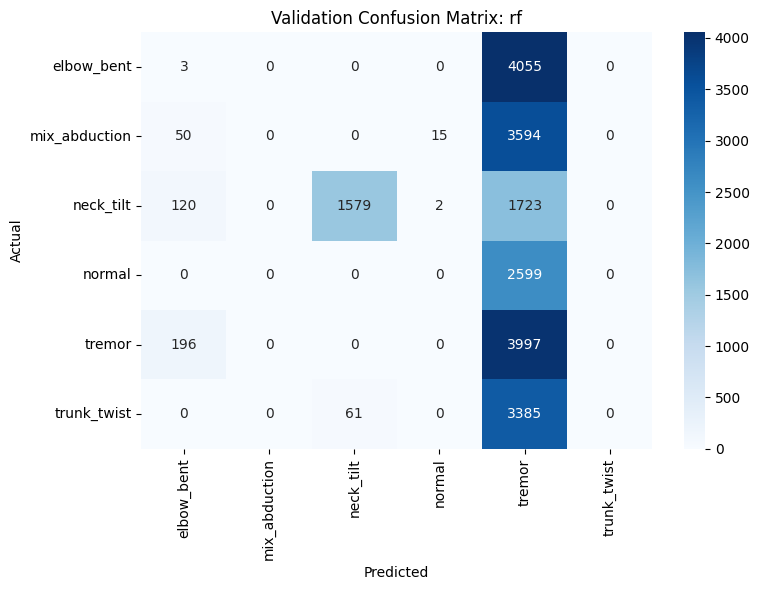

In [ ]:
#ยังไม่ลบ tremor ออก พบว่ายัง ill-defined
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load Datasets ---
train_df = pd.read_csv(r'training_01.csv').dropna()
test_df = pd.read_csv(r'testing_01.csv').dropna()
validate_df = pd.read_csv(r'validate_01.csv').dropna()  # 🔸 วิดีโอคนใหม่ มุมใหม่
'''
#--delete tremor for solve overfit
train_df = train_df[train_df['class_name'] != 'tremor']
test_df = test_df[test_df['class_name'] != 'tremor']
validate_df = validate_df[validate_df['class_name'] != 'tremor']
'''
validate_df['class_name'] = validate_df['class_name'].replace({
    'mix_ab': 'mix_abduction',
    'neck_tlit': 'neck_tilt'
})

# --- Split features & labels ---
def prepare_xy(df):
    X = df.drop(columns=['class_name', 'video_id', 'frame_num'])
    y = df['class_name']
    return X, y

X_train, y_train = prepare_xy(train_df)
X_test, y_test = prepare_xy(test_df)
X_validate, y_validate = prepare_xy(validate_df)

# --- Define Model Pipelines ---
pipelines = {
    'lr': make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    'rc': make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier()),
}

# --- Train + Evaluate All Sets ---
fit_models = {}
for name, model in pipelines.items():
    print(f"\n🔵 Training model: {name}")
    model.fit(X_train, y_train)
    fit_models[name] = model

    for split_name, X, y in [
        ('Train', X_train, y_train),
        ('Test', X_test, y_test),
        ('Validation', X_validate, y_validate),
    ]:
        y_pred = model.predict(X)
        acc = accuracy_score(y, y_pred)
        print(f"✅ {split_name} Accuracy: {acc:.4f}")
        print(classification_report(y, y_pred))

        # --- Confusion Matrix ---
        labels = np.unique(y)
        cm = confusion_matrix(y, y_pred, labels=labels)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels)
        plt.title(f'{split_name} Confusion Matrix: {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()



🔵 Training model: lr
✅ Train Accuracy: 0.9960
               precision    recall  f1-score   support

   elbow_bent       1.00      1.00      1.00      7310
mix_abduction       0.99      0.99      0.99      7121
    neck_tilt       1.00      1.00      1.00      5850
       normal       0.99      0.99      0.99      8186
  trunk_twist       1.00      1.00      1.00      5635

     accuracy                           1.00     34102
    macro avg       1.00      1.00      1.00     34102
 weighted avg       1.00      1.00      1.00     34102



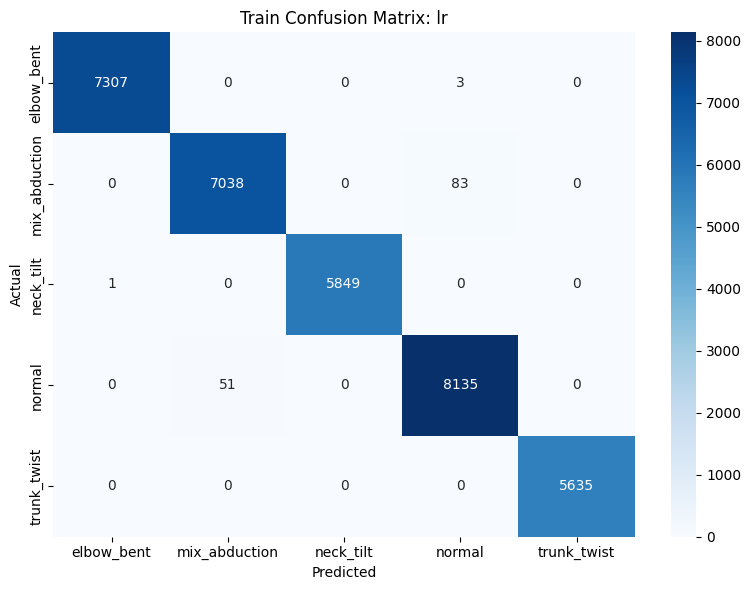

✅ Test Accuracy: 0.9412
               precision    recall  f1-score   support

   elbow_bent       0.97      0.96      0.96      1768
mix_abduction       1.00      0.94      0.97      1901
    neck_tilt       0.83      0.99      0.90      1617
       normal       0.95      0.96      0.96      2079
  trunk_twist       0.99      0.83      0.90      1360

     accuracy                           0.94      8725
    macro avg       0.95      0.94      0.94      8725
 weighted avg       0.95      0.94      0.94      8725



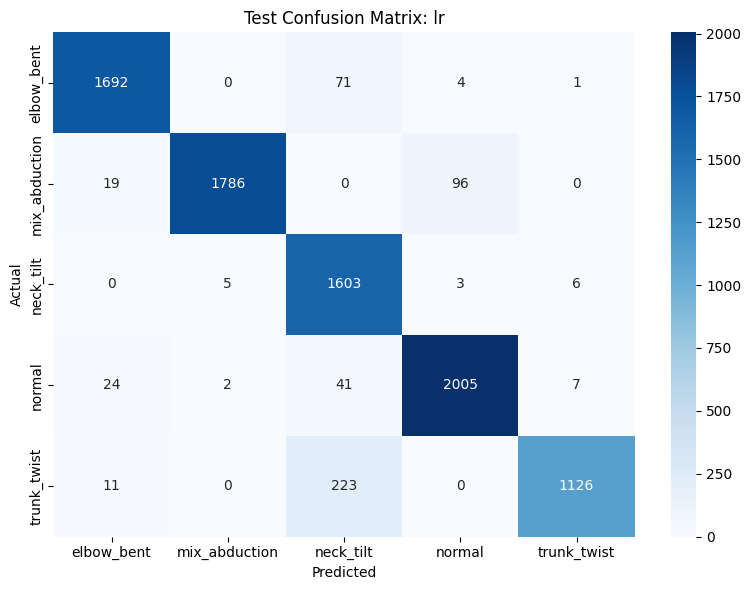

✅ Validation Accuracy: 0.2670
               precision    recall  f1-score   support

   elbow_bent       0.25      1.00      0.40      4058
mix_abduction       0.00      0.00      0.00      3659
    neck_tilt       1.00      0.00      0.00      3424
       normal       0.00      0.00      0.00      2599
  trunk_twist       0.79      0.15      0.26      3446

     accuracy                           0.27     17186
    macro avg       0.41      0.23      0.13     17186
 weighted avg       0.42      0.27      0.15     17186



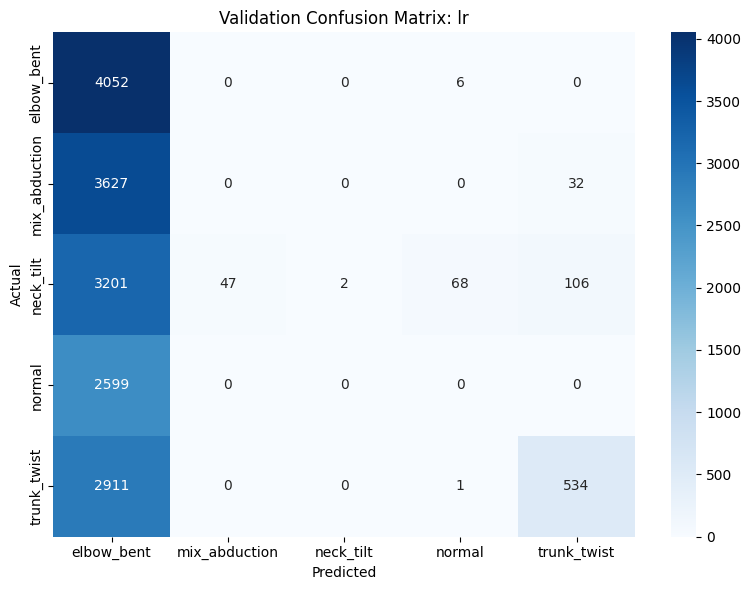


🔵 Training model: rc
✅ Train Accuracy: 0.9772
               precision    recall  f1-score   support

   elbow_bent       1.00      1.00      1.00      7310
mix_abduction       0.94      0.96      0.95      7121
    neck_tilt       1.00      1.00      1.00      5850
       normal       0.96      0.94      0.95      8186
  trunk_twist       1.00      1.00      1.00      5635

     accuracy                           0.98     34102
    macro avg       0.98      0.98      0.98     34102
 weighted avg       0.98      0.98      0.98     34102



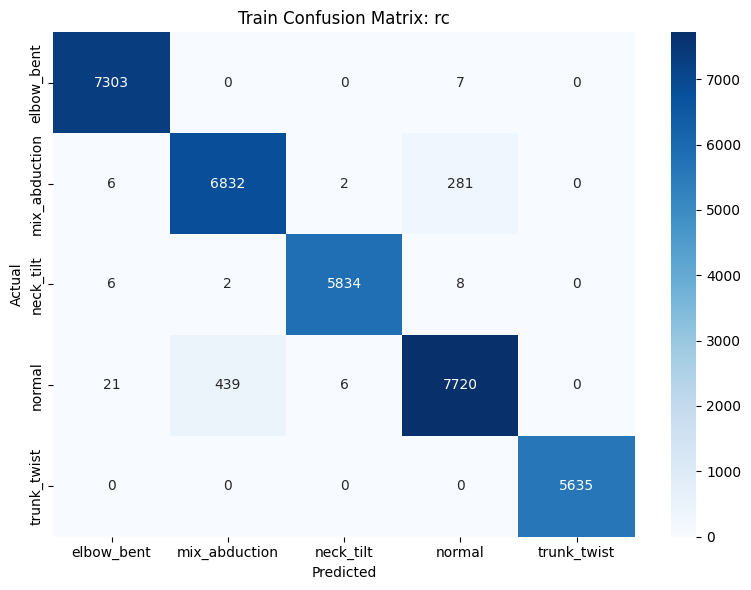

✅ Test Accuracy: 0.9114
               precision    recall  f1-score   support

   elbow_bent       0.92      0.98      0.95      1768
mix_abduction       0.98      0.77      0.86      1901
    neck_tilt       0.91      0.99      0.95      1617
       normal       0.81      0.90      0.85      2079
  trunk_twist       1.00      0.94      0.97      1360

     accuracy                           0.91      8725
    macro avg       0.92      0.92      0.92      8725
 weighted avg       0.92      0.91      0.91      8725



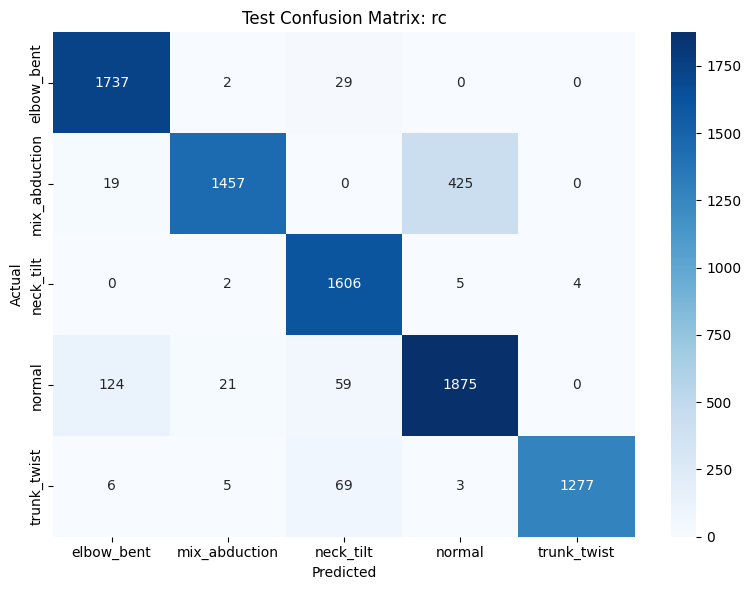

✅ Validation Accuracy: 0.4060
               precision    recall  f1-score   support

   elbow_bent       0.46      0.80      0.58      4058
mix_abduction       0.69      0.15      0.24      3659
    neck_tilt       1.00      0.01      0.01      3424
       normal       0.48      0.14      0.22      2599
  trunk_twist       0.33      0.82      0.47      3446

     accuracy                           0.41     17186
    macro avg       0.59      0.38      0.30     17186
 weighted avg       0.59      0.41      0.32     17186



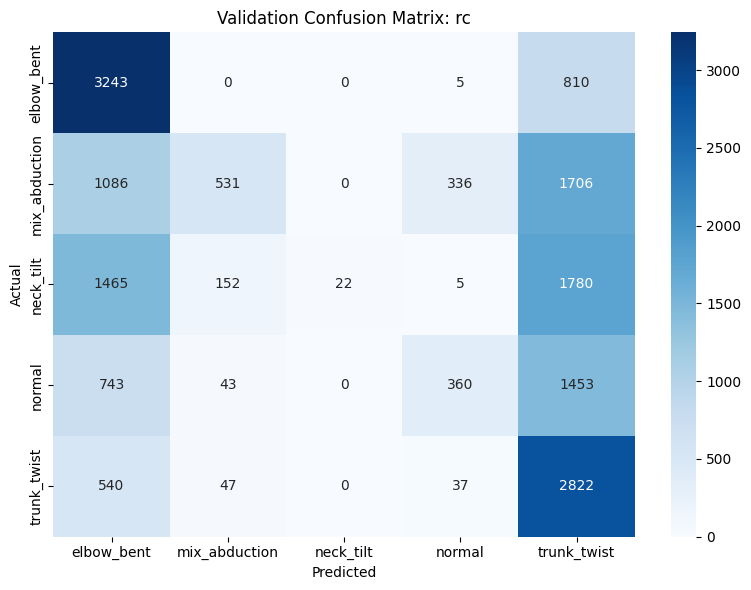


🔵 Training model: rf
✅ Train Accuracy: 1.0000
               precision    recall  f1-score   support

   elbow_bent       1.00      1.00      1.00      7310
mix_abduction       1.00      1.00      1.00      7121
    neck_tilt       1.00      1.00      1.00      5850
       normal       1.00      1.00      1.00      8186
  trunk_twist       1.00      1.00      1.00      5635

     accuracy                           1.00     34102
    macro avg       1.00      1.00      1.00     34102
 weighted avg       1.00      1.00      1.00     34102



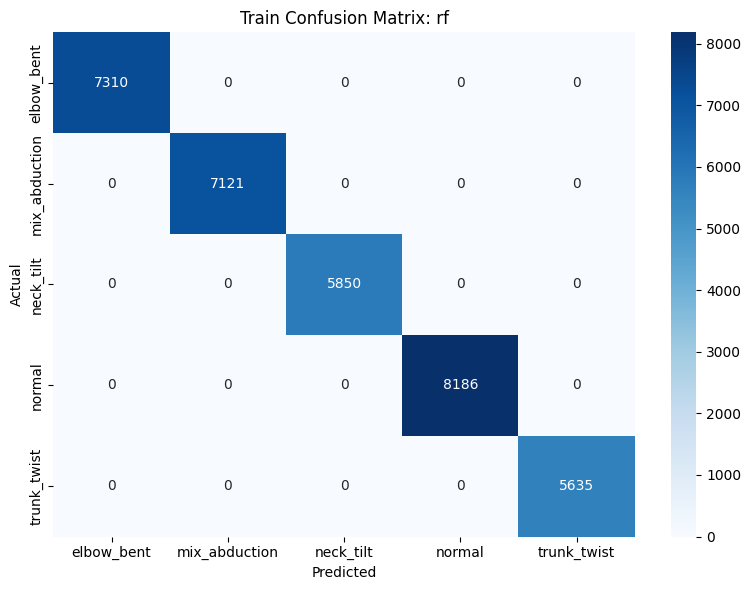

✅ Test Accuracy: 0.9434
               precision    recall  f1-score   support

   elbow_bent       1.00      0.97      0.99      1768
mix_abduction       0.97      0.93      0.95      1901
    neck_tilt       0.87      0.98      0.92      1617
       normal       0.91      0.97      0.94      2079
  trunk_twist       1.00      0.84      0.91      1360

     accuracy                           0.94      8725
    macro avg       0.95      0.94      0.94      8725
 weighted avg       0.95      0.94      0.94      8725



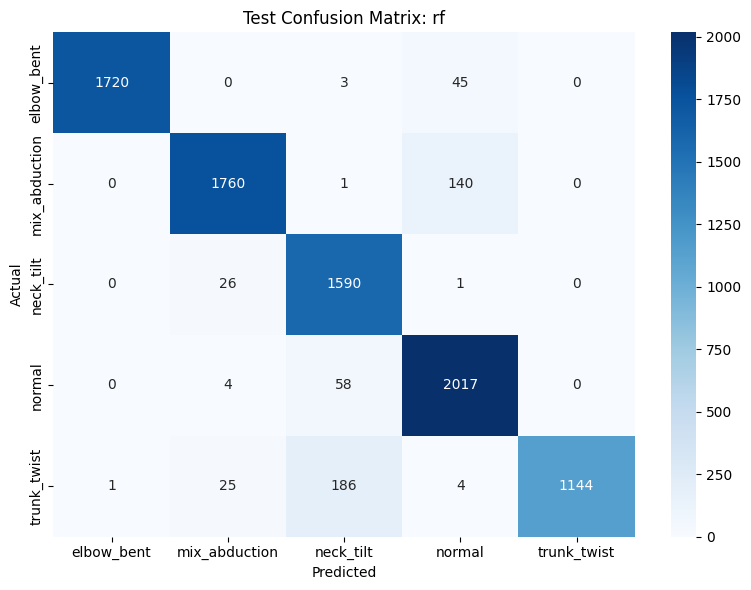

✅ Validation Accuracy: 0.3748
               precision    recall  f1-score   support

   elbow_bent       0.42      0.58      0.49      4058
mix_abduction       0.50      0.01      0.01      3659
    neck_tilt       0.40      0.51      0.45      3424
       normal       0.45      0.26      0.33      2599
  trunk_twist       0.29      0.47      0.36      3446

     accuracy                           0.37     17186
    macro avg       0.41      0.37      0.33     17186
 weighted avg       0.41      0.37      0.33     17186



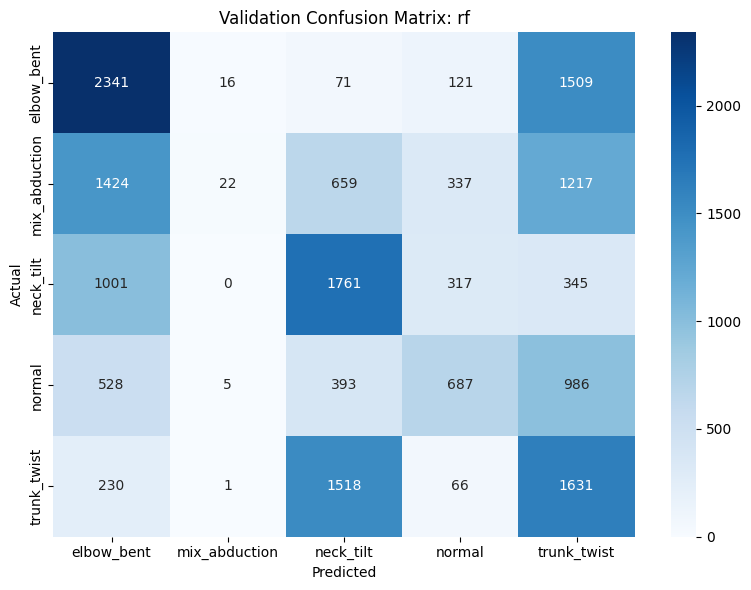

In [1]:
#ลองแก้ overfit โดยลบ tremor ออก และเปลี่ยนชื่อ class บางตัว
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load Datasets ---
train_df = pd.read_csv(r'training_01.csv').dropna()
test_df = pd.read_csv(r'testing_01.csv').dropna()
validate_df = pd.read_csv(r'validate_01.csv').dropna()  # 🔸 วิดีโอคนใหม่ มุมใหม่

#--delete tremor for solve overfit
train_df = train_df[train_df['class_name'] != 'tremor']
test_df = test_df[test_df['class_name'] != 'tremor']
validate_df = validate_df[validate_df['class_name'] != 'tremor']

validate_df['class_name'] = validate_df['class_name'].replace({
    'mix_ab': 'mix_abduction',
    'neck_tlit': 'neck_tilt'
})

# --- Split features & labels ---
def prepare_xy(df):
    X = df.drop(columns=['class_name', 'video_id', 'frame_num'])
    y = df['class_name']
    return X, y

X_train, y_train = prepare_xy(train_df)
X_test, y_test = prepare_xy(test_df)
X_validate, y_validate = prepare_xy(validate_df)

# --- Define Model Pipelines ---
pipelines = {
    'lr': make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    'rc': make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier()),
}

# --- Train + Evaluate All Sets ---
fit_models = {}
for name, model in pipelines.items():
    print(f"\n🔵 Training model: {name}")
    model.fit(X_train, y_train)
    fit_models[name] = model

    for split_name, X, y in [
        ('Train', X_train, y_train),
        ('Test', X_test, y_test),
        ('Validation', X_validate, y_validate),
    ]:
        y_pred = model.predict(X)
        acc = accuracy_score(y, y_pred)
        print(f"✅ {split_name} Accuracy: {acc:.4f}")
        print(classification_report(y, y_pred))

        # --- Confusion Matrix ---
        labels = np.unique(y)
        cm = confusion_matrix(y, y_pred, labels=labels)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels)
        plt.title(f'{split_name} Confusion Matrix: {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()


In [2]:
import pickle
with open('movemate_raw_data_no_tremor_rf.pkl', 'wb') as f:
    pickle.dump(fit_models['rf'], f)

##### พบว่าตัด tremor ออก ill-denied หาย แต่ overfit ยังคงอยู่

### 2.ลองดูจุดที่ v > 0.8

In [21]:
# --- Load Datasets ---
train_df = pd.read_csv(r'training_01.csv').dropna()
test_df = pd.read_csv(r'testing_01.csv').dropna()
validate_df = pd.read_csv(r'validate_01.csv').dropna()  # 🔸 วิดีโอคนใหม่ มุมใหม่

#--delete tremor for solve overfit
train_df = train_df[train_df['class_name'] != 'tremor']
test_df = test_df[test_df['class_name'] != 'tremor']
validate_df = validate_df[validate_df['class_name'] != 'tremor']

validate_df['class_name'] = validate_df['class_name'].replace({
    'mix_ab': 'mix_abduction',
    'neck_tlit': 'neck_tilt'
})

In [29]:
# เพิ่มคอลัมน์ 'source' เพื่อรู้ว่าแต่ละแถวมาจากไหน
train_df['source'] = 'train'
test_df['source'] = 'test'
validate_df['source'] = 'validate'

# รวมทั้งสาม DataFrame เข้าด้วยกัน
full_df = pd.concat([train_df, test_df, validate_df], ignore_index=True)

# แสดงตัวอย่างข้อมูล
print(full_df.shape)


(60013, 136)


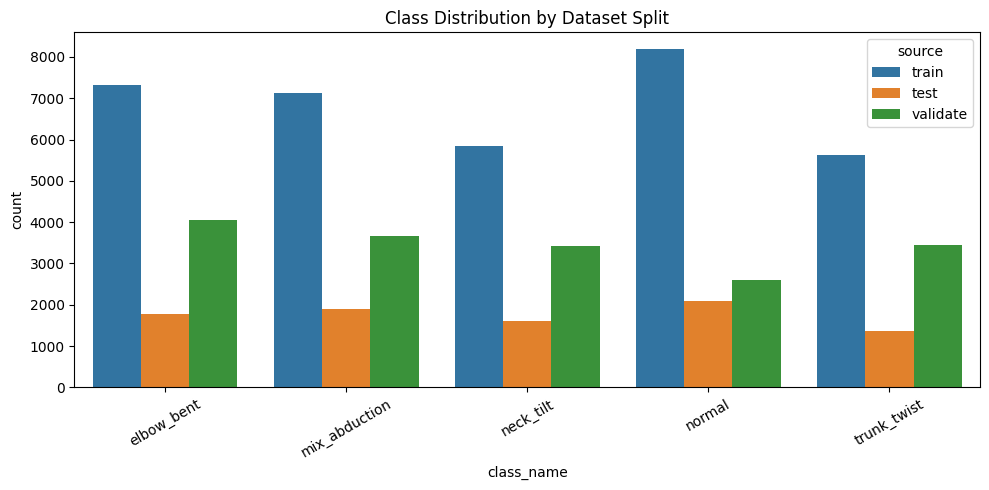

In [30]:
# ดูจำนวนแต่ละ class แยกตามชุดข้อมูล
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.countplot(data=full_df, x='class_name', hue='source')
plt.title('Class Distribution by Dataset Split')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [31]:
full_df

,class_name,video_id,frame_num,nose_x,nose_y,nose_z,nose_visibility,left_eye_inner_x,left_eye_inner_y,left_eye_inner_z,...,right_heel_visibility,left_foot_index_x,left_foot_index_y,left_foot_index_z,left_foot_index_visibility,right_foot_index_x,right_foot_index_y,right_foot_index_z,right_foot_index_visibility,source
0,elbow_bent,202,1,0.629551,0.586767,-0.101589,0.999081,0.651994,0.591047,-0.132424,...,0.120438,-0.122716,0.639270,-0.059814,0.351254,-0.082423,0.601404,0.134656,0.091911,train
1,elbow_bent,202,2,0.629606,0.578487,-0.142896,0.999097,0.652018,0.586756,-0.172358,...,0.123033,-0.099222,0.636656,-0.013470,0.364271,-0.070565,0.599348,0.160483,0.097131,train
2,elbow_bent,202,3,0.629701,0.573519,-0.150741,0.999152,0.652016,0.582640,-0.179749,...,0.125398,-0.102646,0.636517,-0.026013,0.371120,-0.068805,0.599157,0.173074,0.101102,train
3,elbow_bent,202,4,0.630027,0.569661,-0.171752,0.999201,0.652021,0.579365,-0.200532,...,0.132134,-0.105242,0.634359,-0.035223,0.382507,-0.065808,0.598923,0.176708,0.108835,train
4,elbow_bent,202,5,0.629979,0.567085,-0.175057,0.999249,0.651959,0.576749,-0.204510,...,0.136878,-0.106701,0.634775,-0.038096,0.386657,-0.067090,0.598626,0.169579,0.112691,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60008,normal,1,2552,0.541416,0.599411,-0.160529,0.995025,0.559606,0.606539,-0.186648,...,0.112119,-0.116792,0.714248,0.039709,0.290668,-0.086716,0.655211,0.211040,0.078894,validate
60009,normal,1,2553,0.541546,0.597955,-0.164636,0.993700,0.559688,0.605553,-0.190331,...,0.105099,-0.116116,0.712266,0.042583,0.276503,-0.088461,0.655470,0.221211,0.073791,validate
60010,normal,1,2554,0.542873,0.596979,-0.158827,0.992977,0.560764,0.605071,-0.185006,...,0.098676,-0.120253,0.715250,0.045568,0.264582,-0.091821,0.659590,0.235977,0.069219,validate
60011,normal,1,2555,0.543206,0.596472,-0.156424,0.992469,0.561122,0.604676,-0.184024,...,0.092847,-0.123141,0.715624,0.053612,0.252954,-0.094173,0.660884,0.239512,0.064975,validate


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Keypoints สำคัญที่สนใจ
important_keypoints = [landmark.name.lower() for landmark in mp_pose.PoseLandmark] # ปริ้นชื่อ keypoint ทั้งหมดของ mediapipe pose

# สร้าง DataFrame สำหรับสรุปข้อมูล
visibility_summary = pd.DataFrame(columns=['mean', 'min', 'max', 'count_below_0.9'])

for kp in important_keypoints:
    col = f'{kp}_visibility'
    if col in full_df.columns:
        visibility_summary.loc[kp] = {
            'mean': full_df[col].mean(),
            'min': full_df[col].min(),
            'max': full_df[col].max(),
            'count_below_0.9': (full_df[col] < 0.9).sum()
        }

# แสดงผล
print("\n🔍 Visibility Summary for Keypoints:")
print(visibility_summary.sort_values(by='mean'))




🔍 Visibility Summary for Keypoints:
                      mean       min       max  count_below_0.9
right_ankle       0.200663  0.008875  0.642905            60013
right_foot_index  0.265988  0.016619  0.742533            60013
right_knee        0.289933  0.047921  0.785056            60013
right_heel        0.296826  0.022705  0.697520            60013
right_elbow       0.366598  0.055273  0.796547            60013
right_pinky       0.373680  0.053805  0.798788            60013
right_index       0.374129  0.056655  0.795056            60013
right_thumb       0.378590  0.066905  0.794350            60013
right_wrist       0.394056  0.050152  0.812009            60013
left_ankle        0.553117  0.074380  0.902989            60009
left_foot_index   0.566116  0.091910  0.914794            60000
left_heel         0.748171  0.193310  0.939153            56032
left_knee         0.751602  0.328897  0.947598            58627
left_thumb        0.935055  0.306823  0.993847             7159
lef

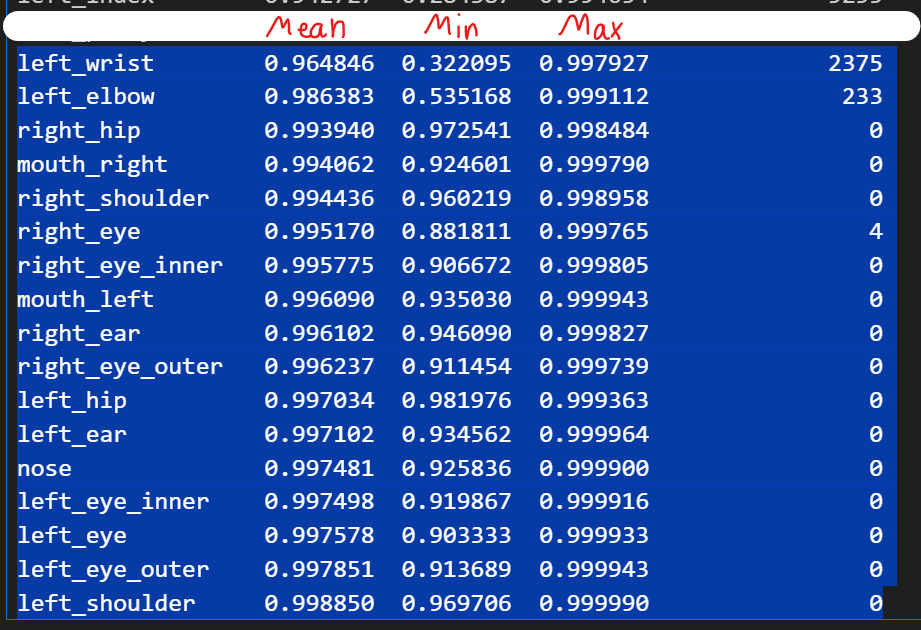

In [66]:
full_df

,class_name,video_id,frame_num,nose_x,nose_y,nose_z,nose_visibility,left_eye_inner_x,left_eye_inner_y,left_eye_inner_z,...,left_foot_index_y,left_foot_index_z,left_foot_index_visibility,right_foot_index_x,right_foot_index_y,right_foot_index_z,right_foot_index_visibility,source,visibility_mean,visibility_below_0.9_count
0,elbow_bent,202,1,0.629551,0.586767,-0.101589,0.999081,0.651994,0.591047,-0.132424,...,0.639270,-0.059814,0.351254,-0.082423,0.601404,0.134656,0.091911,train,0.731882,13
1,elbow_bent,202,2,0.629606,0.578487,-0.142896,0.999097,0.652018,0.586756,-0.172358,...,0.636656,-0.013470,0.364271,-0.070565,0.599348,0.160483,0.097131,train,0.733556,13
2,elbow_bent,202,3,0.629701,0.573519,-0.150741,0.999152,0.652016,0.582640,-0.179749,...,0.636517,-0.026013,0.371120,-0.068805,0.599157,0.173074,0.101102,train,0.736760,13
3,elbow_bent,202,4,0.630027,0.569661,-0.171752,0.999201,0.652021,0.579365,-0.200532,...,0.634359,-0.035223,0.382507,-0.065808,0.598923,0.176708,0.108835,train,0.739135,13
4,elbow_bent,202,5,0.629979,0.567085,-0.175057,0.999249,0.651959,0.576749,-0.204510,...,0.634775,-0.038096,0.386657,-0.067090,0.598626,0.169579,0.112691,train,0.741236,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60008,normal,1,2552,0.541416,0.599411,-0.160529,0.995025,0.559606,0.606539,-0.186648,...,0.714248,0.039709,0.290668,-0.086716,0.655211,0.211040,0.078894,validate,0.692990,13
60009,normal,1,2553,0.541546,0.597955,-0.164636,0.993700,0.559688,0.605553,-0.190331,...,0.712266,0.042583,0.276503,-0.088461,0.655470,0.221211,0.073791,validate,0.686686,13
60010,normal,1,2554,0.542873,0.596979,-0.158827,0.992977,0.560764,0.605071,-0.185006,...,0.715250,0.045568,0.264582,-0.091821,0.659590,0.235977,0.069219,validate,0.681542,13
60011,normal,1,2555,0.543206,0.596472,-0.156424,0.992469,0.561122,0.604676,-0.184024,...,0.715624,0.053612,0.252954,-0.094173,0.660884,0.239512,0.064975,validate,0.676827,13


In [67]:
# รายชื่อ keypoints ที่ต้องการเก็บ
important_keypoints = [
    'left_wrist', 'left_elbow', 'right_hip', 'mouth_right', 'right_shoulder',
    'right_eye', 'right_eye_inner', 'mouth_left', 'right_ear', 'right_eye_outer',
    'left_hip', 'left_ear', 'nose', 'left_eye_inner', 'left_eye', 'left_eye_outer',
    'left_shoulder'
]

# คอลัมน์ metadata ที่ควรเก็บด้วย เช่น class, frame number, video_id
metadata_cols = ['class_name', 'video_id', 'frame_num','source']  # ปรับตามที่คุณมีจริง

# สร้างชื่อคอลัมน์ keypoints ทั้งหมด (x, y, z, visibility)
keypoint_cols = []
for kp in important_keypoints:
    keypoint_cols += [f'{kp}_x', f'{kp}_y', f'{kp}_z', f'{kp}_visibility']

# รวมทั้งหมดที่ต้องการเก็บไว้
final_cols = metadata_cols + keypoint_cols

# ตรวจสอบว่าคอลัมน์ไหนมีจริงใน train_df
existing_cols = [col for col in final_cols if col in full_df.columns]

# สร้าง DataFrame ใหม่จากคอลัมน์ที่มีอยู่จริง
filtered_full_df = full_df[existing_cols].copy()

In [68]:
filtered_full_df

,class_name,video_id,frame_num,source,left_wrist_x,left_wrist_y,left_wrist_z,left_wrist_visibility,left_elbow_x,left_elbow_y,...,left_eye_z,left_eye_visibility,left_eye_outer_x,left_eye_outer_y,left_eye_outer_z,left_eye_outer_visibility,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_visibility
0,elbow_bent,202,1,train,0.279877,0.793893,-0.254027,0.996847,0.420801,0.799299,...,-0.132456,0.999328,0.655187,0.599388,-0.132545,0.999449,0.570814,0.768073,-0.266946,0.999953
1,elbow_bent,202,2,train,0.279671,0.793907,-0.277528,0.996586,0.420317,0.799777,...,-0.172428,0.999346,0.655196,0.595933,-0.172544,0.999465,0.571340,0.770512,-0.277161,0.999955
2,elbow_bent,202,3,train,0.279638,0.794019,-0.287221,0.996613,0.418574,0.800869,...,-0.179791,0.999389,0.655196,0.593029,-0.179900,0.999500,0.571409,0.771596,-0.283330,0.999958
3,elbow_bent,202,4,train,0.279532,0.794016,-0.298430,0.996514,0.418237,0.801696,...,-0.200552,0.999428,0.655196,0.590219,-0.200665,0.999530,0.571468,0.771977,-0.298460,0.999961
4,elbow_bent,202,5,train,0.279508,0.793984,-0.292591,0.996391,0.418133,0.802271,...,-0.204521,0.999464,0.655167,0.587796,-0.204635,0.999560,0.571539,0.772660,-0.300795,0.999963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60008,normal,1,2552,validate,0.182498,0.766639,-0.329436,0.964722,0.319551,0.749023,...,-0.186740,0.995457,0.562192,0.615510,-0.186868,0.996541,0.485605,0.741144,-0.325402,0.998861
60009,normal,1,2553,validate,0.178632,0.780169,-0.325602,0.963428,0.318911,0.754264,...,-0.190417,0.994517,0.562248,0.614559,-0.190560,0.995849,0.484943,0.742045,-0.322081,0.998885
60010,normal,1,2554,validate,0.178478,0.786329,-0.323095,0.962568,0.318520,0.756470,...,-0.185098,0.993970,0.563068,0.614108,-0.185239,0.995466,0.484123,0.741971,-0.320008,0.998923
60011,normal,1,2555,validate,0.175236,0.790109,-0.314642,0.961355,0.318298,0.755020,...,-0.184122,0.993542,0.563356,0.613795,-0.184217,0.995177,0.483296,0.740700,-0.307899,0.998970


In [69]:
# แยกตามค่าคอลัมน์ 'source'
filtered_train_df = filtered_full_df[filtered_full_df['source'] == 'train'].copy()
filtered_test_df  = filtered_full_df[filtered_full_df['source'] == 'test'].copy()
filtered_validate_df   = filtered_full_df[filtered_full_df['source'] == 'validate'].copy()

# ตรวจสอบขนาดของแต่ละชุด
print(f"✅ Train set: {filtered_train_df.shape}")
print(f"✅ Test set:  {filtered_test_df.shape}")
print(f"✅ Validate set:   {filtered_validate_df.shape}")


✅ Train set: (34102, 72)
✅ Test set:  (8725, 72)
✅ Validate set:   (17186, 72)


In [70]:
filtered_train_df.drop(columns=['source'], inplace=True)
filtered_test_df.drop(columns=['source'], inplace=True)
filtered_validate_df.drop(columns=['source'], inplace=True)

In [71]:
print(f"✅ Train set: {filtered_train_df.shape}")
print(f"✅ Test set:  {filtered_test_df.shape}")
print(f"✅ Validate set:   {filtered_validate_df.shape}")

✅ Train set: (34102, 71)
✅ Test set:  (8725, 71)
✅ Validate set:   (17186, 71)


In [72]:
filtered_train_df

,class_name,video_id,frame_num,left_wrist_x,left_wrist_y,left_wrist_z,left_wrist_visibility,left_elbow_x,left_elbow_y,left_elbow_z,...,left_eye_z,left_eye_visibility,left_eye_outer_x,left_eye_outer_y,left_eye_outer_z,left_eye_outer_visibility,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_visibility
0,elbow_bent,202,1,0.279877,0.793893,-0.254027,0.996847,0.420801,0.799299,-0.275945,...,-0.132456,0.999328,0.655187,0.599388,-0.132545,0.999449,0.570814,0.768073,-0.266946,0.999953
1,elbow_bent,202,2,0.279671,0.793907,-0.277528,0.996586,0.420317,0.799777,-0.285725,...,-0.172428,0.999346,0.655196,0.595933,-0.172544,0.999465,0.571340,0.770512,-0.277161,0.999955
2,elbow_bent,202,3,0.279638,0.794019,-0.287221,0.996613,0.418574,0.800869,-0.292258,...,-0.179791,0.999389,0.655196,0.593029,-0.179900,0.999500,0.571409,0.771596,-0.283330,0.999958
3,elbow_bent,202,4,0.279532,0.794016,-0.298430,0.996514,0.418237,0.801696,-0.303689,...,-0.200552,0.999428,0.655196,0.590219,-0.200665,0.999530,0.571468,0.771977,-0.298460,0.999961
4,elbow_bent,202,5,0.279508,0.793984,-0.292591,0.996391,0.418133,0.802271,-0.302594,...,-0.204521,0.999464,0.655167,0.587796,-0.204635,0.999560,0.571539,0.772660,-0.300795,0.999963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34097,trunk_twist,205,1351,0.268547,0.772701,-0.279898,0.985429,0.403048,0.784309,-0.311486,...,-0.225990,0.999629,0.656031,0.608846,-0.226117,0.999669,0.554879,0.757137,-0.334303,0.999922
34098,trunk_twist,205,1352,0.268589,0.772567,-0.279226,0.985135,0.403030,0.784117,-0.310779,...,-0.224956,0.999631,0.655906,0.608847,-0.225084,0.999671,0.554866,0.757210,-0.333512,0.999920
34099,trunk_twist,205,1353,0.268718,0.772448,-0.279150,0.984839,0.403018,0.783963,-0.309277,...,-0.224454,0.999634,0.655737,0.608883,-0.224579,0.999673,0.554858,0.757272,-0.330797,0.999919
34100,trunk_twist,205,1354,0.269804,0.772689,-0.267227,0.983897,0.403285,0.783934,-0.300166,...,-0.221113,0.999635,0.655140,0.609280,-0.221239,0.999673,0.554825,0.757254,-0.323810,0.999917


#### train


🔵 Training model: lr
✅ Train Accuracy: 0.9889
               precision    recall  f1-score   support

   elbow_bent       1.00      1.00      1.00      7310
mix_abduction       0.97      0.98      0.98      7121
    neck_tilt       1.00      1.00      1.00      5850
       normal       0.98      0.98      0.98      8186
  trunk_twist       1.00      1.00      1.00      5635

     accuracy                           0.99     34102
    macro avg       0.99      0.99      0.99     34102
 weighted avg       0.99      0.99      0.99     34102



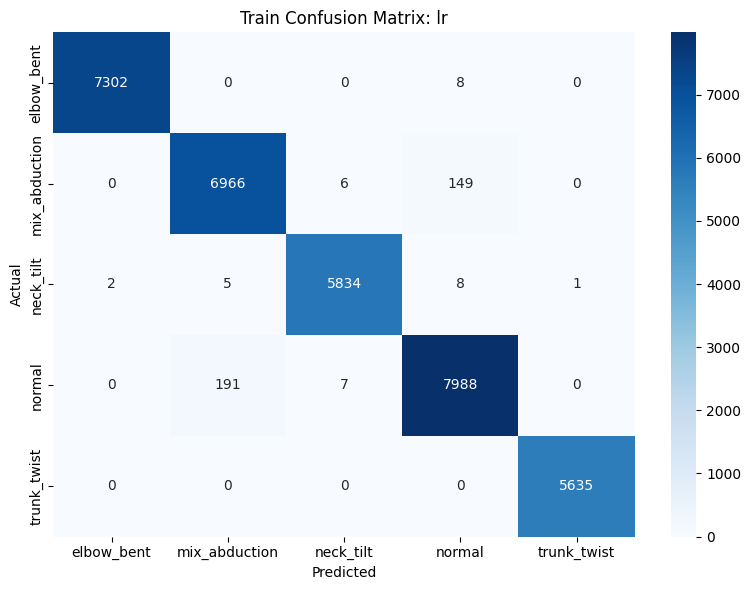

✅ Test Accuracy: 0.9042
               precision    recall  f1-score   support

   elbow_bent       0.92      0.97      0.95      1768
mix_abduction       0.99      0.92      0.95      1901
    neck_tilt       0.74      0.99      0.85      1617
       normal       0.94      0.87      0.90      2079
  trunk_twist       1.00      0.74      0.85      1360

     accuracy                           0.90      8725
    macro avg       0.92      0.90      0.90      8725
 weighted avg       0.92      0.90      0.90      8725



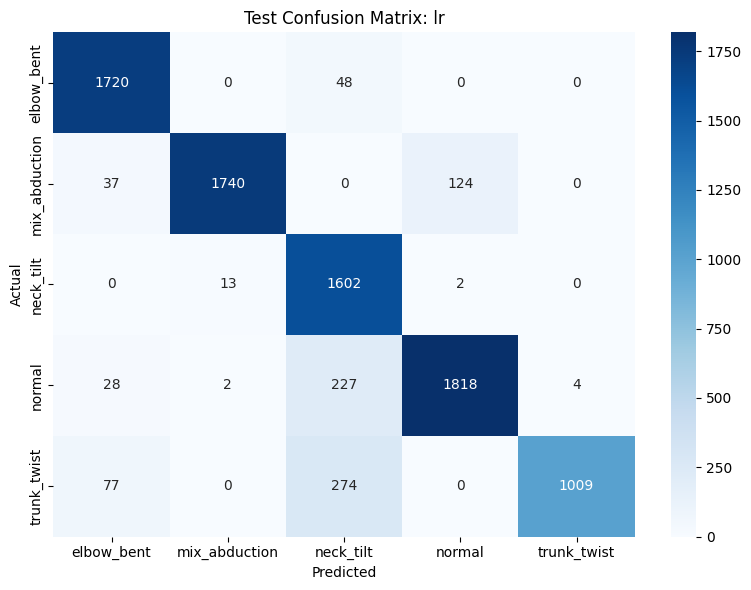

✅ Validation Accuracy: 0.2479
               precision    recall  f1-score   support

   elbow_bent       0.25      0.99      0.39      4058
mix_abduction       0.01      0.00      0.00      3659
    neck_tilt       0.00      0.00      0.00      3424
       normal       0.02      0.00      0.00      2599
  trunk_twist       0.84      0.06      0.12      3446

     accuracy                           0.25     17186
    macro avg       0.22      0.21      0.10     17186
 weighted avg       0.23      0.25      0.12     17186



d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


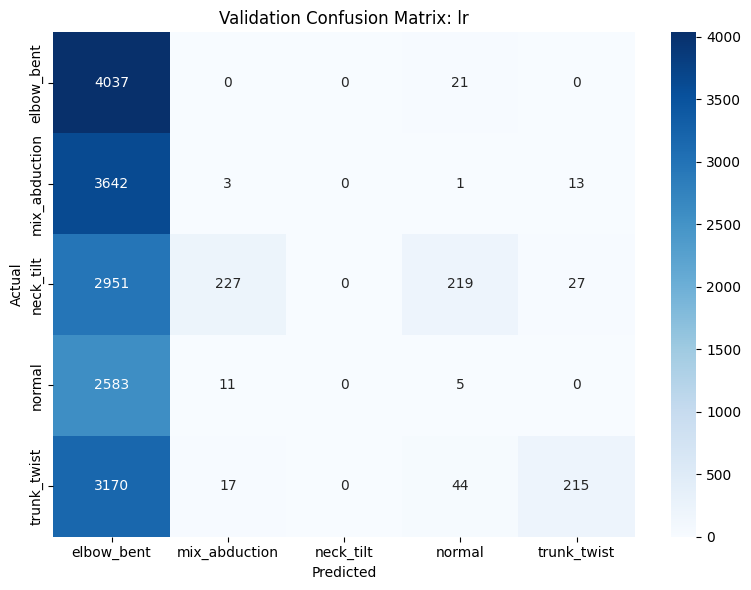


🔵 Training model: rc
✅ Train Accuracy: 0.9587
               precision    recall  f1-score   support

   elbow_bent       0.99      1.00      0.99      7310
mix_abduction       0.89      0.96      0.92      7121
    neck_tilt       0.98      0.99      0.99      5850
       normal       0.95      0.88      0.91      8186
  trunk_twist       1.00      1.00      1.00      5635

     accuracy                           0.96     34102
    macro avg       0.96      0.96      0.96     34102
 weighted avg       0.96      0.96      0.96     34102



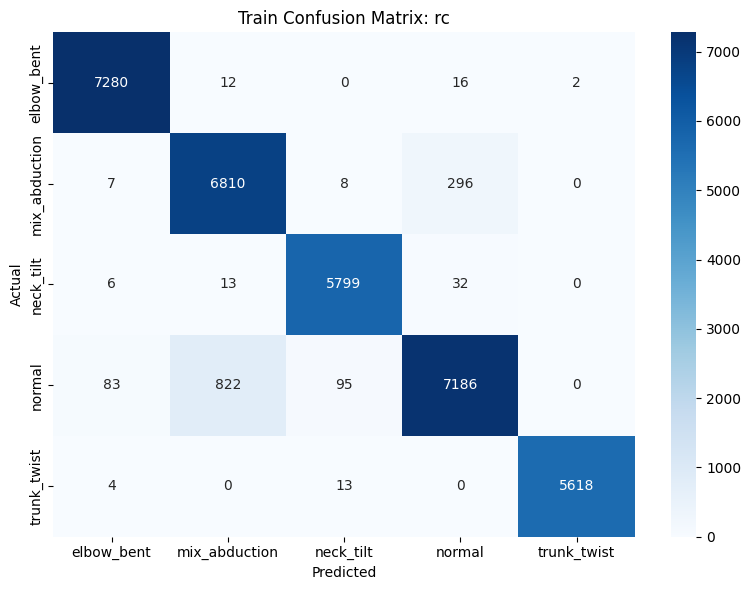

✅ Test Accuracy: 0.8755
               precision    recall  f1-score   support

   elbow_bent       0.91      0.99      0.95      1768
mix_abduction       0.96      0.73      0.83      1901
    neck_tilt       0.81      0.97      0.89      1617
       normal       0.79      0.89      0.84      2079
  trunk_twist       1.00      0.80      0.89      1360

     accuracy                           0.88      8725
    macro avg       0.89      0.88      0.88      8725
 weighted avg       0.89      0.88      0.87      8725



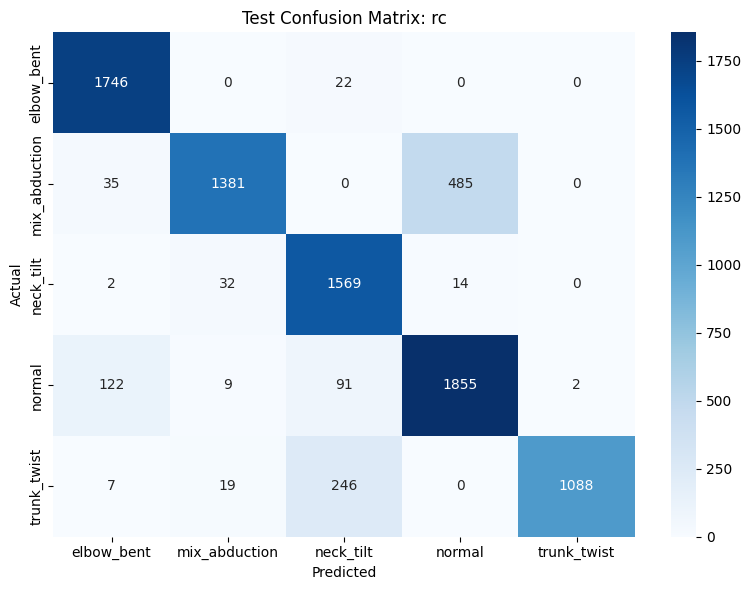

✅ Validation Accuracy: 0.3272
               precision    recall  f1-score   support

   elbow_bent       0.27      0.99      0.43      4058
mix_abduction       0.06      0.00      0.00      3659
    neck_tilt       1.00      0.00      0.00      3424
       normal       0.00      0.00      0.00      2599
  trunk_twist       0.67      0.46      0.54      3446

     accuracy                           0.33     17186
    macro avg       0.40      0.29      0.20     17186
 weighted avg       0.41      0.33      0.21     17186



d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\I'm a doctor\AI PT Coach\rehab-ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


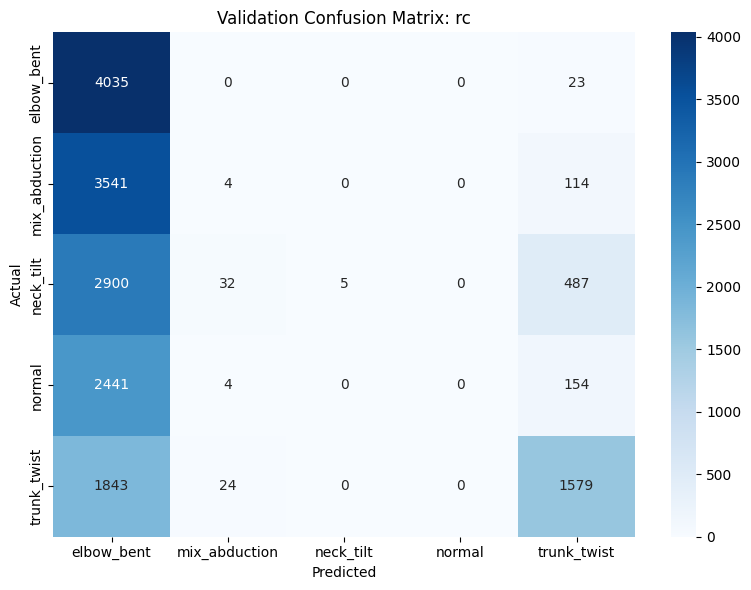


🔵 Training model: rf
✅ Train Accuracy: 1.0000
               precision    recall  f1-score   support

   elbow_bent       1.00      1.00      1.00      7310
mix_abduction       1.00      1.00      1.00      7121
    neck_tilt       1.00      1.00      1.00      5850
       normal       1.00      1.00      1.00      8186
  trunk_twist       1.00      1.00      1.00      5635

     accuracy                           1.00     34102
    macro avg       1.00      1.00      1.00     34102
 weighted avg       1.00      1.00      1.00     34102



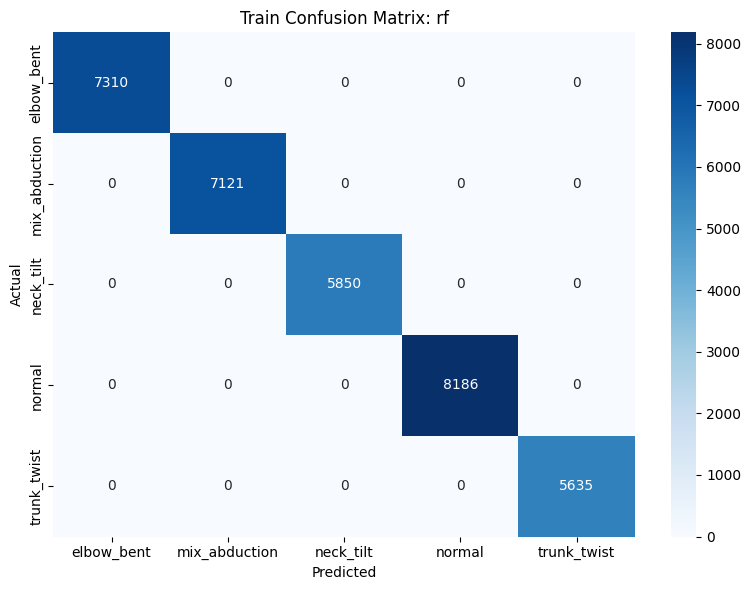

✅ Test Accuracy: 0.9317
               precision    recall  f1-score   support

   elbow_bent       1.00      0.97      0.99      1768
mix_abduction       0.97      0.89      0.93      1901
    neck_tilt       0.85      0.98      0.91      1617
       normal       0.89      0.97      0.93      2079
  trunk_twist       1.00      0.82      0.90      1360

     accuracy                           0.93      8725
    macro avg       0.94      0.93      0.93      8725
 weighted avg       0.94      0.93      0.93      8725



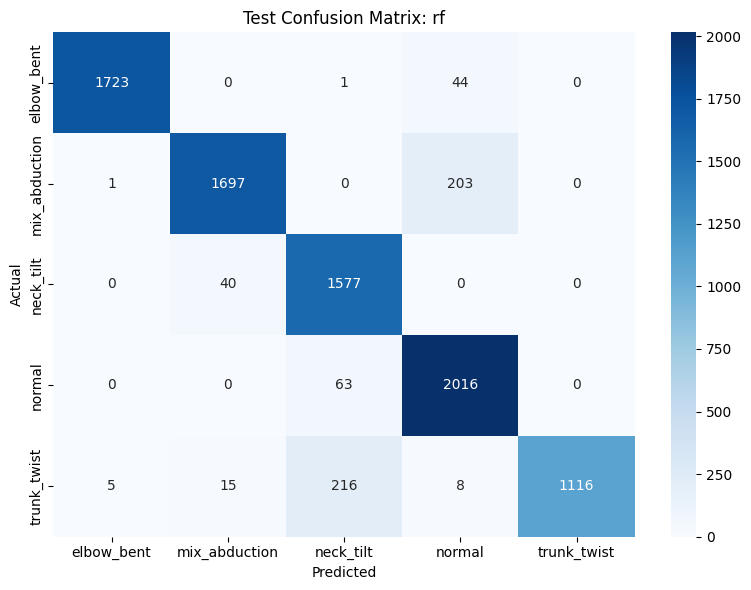

✅ Validation Accuracy: 0.4156
               precision    recall  f1-score   support

   elbow_bent       0.32      0.73      0.44      4058
mix_abduction       1.00      0.00      0.01      3659
    neck_tilt       0.96      0.47      0.63      3424
       normal       0.38      0.23      0.29      2599
  trunk_twist       0.42      0.56      0.48      3446

     accuracy                           0.42     17186
    macro avg       0.62      0.40      0.37     17186
 weighted avg       0.62      0.42      0.37     17186



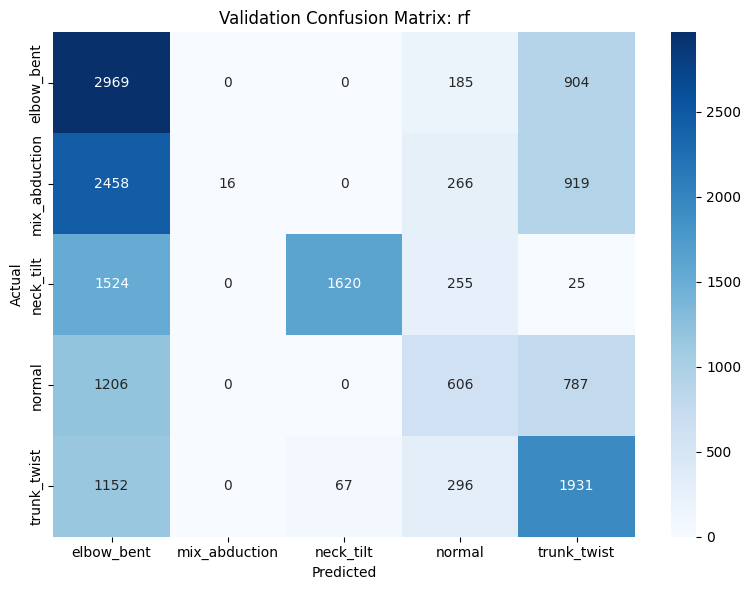

In [73]:
#train ด้วย filtered df
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# --- Split features & labels ---
def prepare_xy(df):
    X = df.drop(columns=['class_name', 'video_id', 'frame_num'])
    y = df['class_name']
    return X, y

X_train, y_train = prepare_xy(filtered_train_df)
X_test, y_test = prepare_xy(filtered_test_df)
X_validate, y_validate = prepare_xy(filtered_validate_df)

# --- Define Model Pipelines ---
pipelines = {
    'lr': make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    'rc': make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier()),
}

# --- Train + Evaluate All Sets ---
fit_models = {}
for name, model in pipelines.items():
    print(f"\n🔵 Training model: {name}")
    model.fit(X_train, y_train)
    fit_models[name] = model

    for split_name, X, y in [
        ('Train', X_train, y_train),
        ('Test', X_test, y_test),
        ('Validation', X_validate, y_validate),
    ]:
        y_pred = model.predict(X)
        acc = accuracy_score(y, y_pred)
        print(f"✅ {split_name} Accuracy: {acc:.4f}")
        print(classification_report(y, y_pred))

        # --- Confusion Matrix ---
        labels = np.unique(y)
        cm = confusion_matrix(y, y_pred, labels=labels)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels)
        plt.title(f'{split_name} Confusion Matrix: {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()


In [74]:
import pickle
with open('movemate_17keys_rf.pkl', 'wb') as f:
    pickle.dump(fit_models['rf'], f)

### 3.เพิ่มfeature เข้าไป

In [76]:
feature_filtered_train_df = filtered_train_df.copy()
feature_filtered_test_df = filtered_test_df.copy()
feature_filtered_validate_df = filtered_validate_df.copy()

#### feature_filtered_train_df

In [77]:
import numpy as np

def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    return np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))

# สร้างคอลัมน์ใหม่
feature_filtered_train_df['dist_shoulder_elbow'] = 0.0
feature_filtered_train_df['dist_elbow_wrist'] = 0.0
feature_filtered_train_df['dist_shoulder_hip'] = 0.0

feature_filtered_train_df['angle_elbow'] = 0.0
feature_filtered_train_df['angle_torso'] = 0.0
feature_filtered_train_df['angle_shoulder'] = 0.0

feature_filtered_train_df

,class_name,video_id,frame_num,left_wrist_x,left_wrist_y,left_wrist_z,left_wrist_visibility,left_elbow_x,left_elbow_y,left_elbow_z,...,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_visibility,dist_shoulder_elbow,dist_elbow_wrist,dist_shoulder_hip,angle_elbow,angle_torso,angle_shoulder
0,elbow_bent,202,1,0.279877,0.793893,-0.254027,0.996847,0.420801,0.799299,-0.275945,...,0.570814,0.768073,-0.266946,0.999953,0.0,0.0,0.0,0.0,0.0,0.0
1,elbow_bent,202,2,0.279671,0.793907,-0.277528,0.996586,0.420317,0.799777,-0.285725,...,0.571340,0.770512,-0.277161,0.999955,0.0,0.0,0.0,0.0,0.0,0.0
2,elbow_bent,202,3,0.279638,0.794019,-0.287221,0.996613,0.418574,0.800869,-0.292258,...,0.571409,0.771596,-0.283330,0.999958,0.0,0.0,0.0,0.0,0.0,0.0
3,elbow_bent,202,4,0.279532,0.794016,-0.298430,0.996514,0.418237,0.801696,-0.303689,...,0.571468,0.771977,-0.298460,0.999961,0.0,0.0,0.0,0.0,0.0,0.0
4,elbow_bent,202,5,0.279508,0.793984,-0.292591,0.996391,0.418133,0.802271,-0.302594,...,0.571539,0.772660,-0.300795,0.999963,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34097,trunk_twist,205,1351,0.268547,0.772701,-0.279898,0.985429,0.403048,0.784309,-0.311486,...,0.554879,0.757137,-0.334303,0.999922,0.0,0.0,0.0,0.0,0.0,0.0
34098,trunk_twist,205,1352,0.268589,0.772567,-0.279226,0.985135,0.403030,0.784117,-0.310779,...,0.554866,0.757210,-0.333512,0.999920,0.0,0.0,0.0,0.0,0.0,0.0
34099,trunk_twist,205,1353,0.268718,0.772448,-0.279150,0.984839,0.403018,0.783963,-0.309277,...,0.554858,0.757272,-0.330797,0.999919,0.0,0.0,0.0,0.0,0.0,0.0
34100,trunk_twist,205,1354,0.269804,0.772689,-0.267227,0.983897,0.403285,0.783934,-0.300166,...,0.554825,0.757254,-0.323810,0.999917,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
# วนผ่านแต่ละ row เพื่อเติมค่าฟีเจอร์
for i, row in feature_filtered_train_df.iterrows():
    # จุดสำหรับระยะ
    ls = (row['left_shoulder_x'], row['left_shoulder_y'])
    le = (row['left_elbow_x'], row['left_elbow_y'])
    lw = (row['left_wrist_x'], row['left_wrist_y'])
    lh = (row['left_hip_x'], row['left_hip_y'])
    le = (row['left_elbow_x'], row['left_elbow_y'])

    # จุดสำหรับมุม
    le = (row['left_elbow_x'], row['left_elbow_y'])
    re = (row['right_elbow_x'], row['right_elbow_y']) if 'right_elbow_x' in row else (0, 0)
    lew = (row['left_wrist_x'], row['left_wrist_y'])
    ear = (row['left_ear_x'], row['left_ear_y']) if 'left_ear_x' in row else (0, 0)

    # Distances
    feature_filtered_train_df.at[i, 'dist_shoulder_elbow'] = euclidean_distance(*ls, *le)
    feature_filtered_train_df.at[i, 'dist_elbow_wrist'] = euclidean_distance(*le, *lw)
    feature_filtered_train_df.at[i, 'dist_shoulder_hip'] = euclidean_distance(*ls, *lh)

    # Angles
    feature_filtered_train_df.at[i, 'angle_elbow'] = calculate_angle(ls, le, lw)  # มุมข้อศอก
    feature_filtered_train_df.at[i, 'angle_torso'] = calculate_angle(lh, ls, ear)  # มุมเอียงตัว/คอ
    feature_filtered_train_df.at[i, 'angle_shoulder'] = calculate_angle(lh, ls, le) # มุมหัวไหล่

In [79]:
feature_filtered_train_df

,class_name,video_id,frame_num,left_wrist_x,left_wrist_y,left_wrist_z,left_wrist_visibility,left_elbow_x,left_elbow_y,left_elbow_z,...,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_visibility,dist_shoulder_elbow,dist_elbow_wrist,dist_shoulder_hip,angle_elbow,angle_torso,angle_shoulder
0,elbow_bent,202,1,0.279877,0.793893,-0.254027,0.996847,0.420801,0.799299,-0.275945,...,0.570814,0.768073,-0.266946,0.999953,0.153228,0.141027,0.269253,166.045129,118.915186,19.629260
1,elbow_bent,202,2,0.279671,0.793907,-0.277528,0.996586,0.420317,0.799777,-0.285725,...,0.571340,0.770512,-0.277161,0.999955,0.153832,0.140768,0.266430,166.643313,116.024425,19.320177
2,elbow_bent,202,3,0.279638,0.794019,-0.287221,0.996613,0.418574,0.800869,-0.292258,...,0.571409,0.771596,-0.283330,0.999958,0.155614,0.139105,0.266417,166.334555,114.694457,19.432107
3,elbow_bent,202,4,0.279532,0.794016,-0.298430,0.996514,0.418237,0.801696,-0.303689,...,0.571468,0.771977,-0.298460,0.999961,0.156086,0.138918,0.266613,165.854664,113.813572,19.659288
4,elbow_bent,202,5,0.279508,0.793984,-0.292591,0.996391,0.418133,0.802271,-0.302594,...,0.571539,0.772660,-0.300795,0.999963,0.156238,0.138872,0.266587,165.653967,112.948015,19.734405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34097,trunk_twist,205,1351,0.268547,0.772701,-0.279898,0.985429,0.403048,0.784309,-0.311486,...,0.554879,0.757137,-0.334303,0.999922,0.154243,0.135001,0.264336,164.921259,123.076679,20.296498
34098,trunk_twist,205,1352,0.268589,0.772567,-0.279226,0.985135,0.403030,0.784117,-0.310779,...,0.554866,0.757210,-0.333512,0.999920,0.154202,0.134937,0.264333,165.040753,123.023003,20.231204
34099,trunk_twist,205,1353,0.268718,0.772448,-0.279150,0.984839,0.403018,0.783963,-0.309277,...,0.554858,0.757272,-0.330797,0.999919,0.154168,0.134793,0.264291,165.129254,122.976257,20.190582
34100,trunk_twist,205,1354,0.269804,0.772689,-0.267227,0.983897,0.403285,0.783934,-0.300166,...,0.554825,0.757254,-0.323810,0.999917,0.153871,0.133954,0.264222,165.199343,123.005878,20.207518


#### feature_filtered_test_df

In [80]:
import numpy as np

def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    return np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))

# สร้างคอลัมน์ใหม่
feature_filtered_test_df['dist_shoulder_elbow'] = 0.0
feature_filtered_test_df['dist_elbow_wrist'] = 0.0
feature_filtered_test_df['dist_shoulder_hip'] = 0.0

feature_filtered_test_df['angle_elbow'] = 0.0
feature_filtered_test_df['angle_torso'] = 0.0
feature_filtered_test_df['angle_shoulder'] = 0.0

# วนผ่านแต่ละ row เพื่อเติมค่าฟีเจอร์
for i, row in feature_filtered_test_df.iterrows():
    # จุดสำหรับระยะ
    ls = (row['left_shoulder_x'], row['left_shoulder_y'])
    le = (row['left_elbow_x'], row['left_elbow_y'])
    lw = (row['left_wrist_x'], row['left_wrist_y'])
    lh = (row['left_hip_x'], row['left_hip_y'])
    le = (row['left_elbow_x'], row['left_elbow_y'])

    # จุดสำหรับมุม
    le = (row['left_elbow_x'], row['left_elbow_y'])
    re = (row['right_elbow_x'], row['right_elbow_y']) if 'right_elbow_x' in row else (0, 0)
    lew = (row['left_wrist_x'], row['left_wrist_y'])
    ear = (row['left_ear_x'], row['left_ear_y']) if 'left_ear_x' in row else (0, 0)

    # Distances
    feature_filtered_test_df.at[i, 'dist_shoulder_elbow'] = euclidean_distance(*ls, *le)
    feature_filtered_test_df.at[i, 'dist_elbow_wrist'] = euclidean_distance(*le, *lw)
    feature_filtered_test_df.at[i, 'dist_shoulder_hip'] = euclidean_distance(*ls, *lh)

    # Angles
    feature_filtered_test_df.at[i, 'angle_elbow'] = calculate_angle(ls, le, lw)  # มุมข้อศอก
    feature_filtered_test_df.at[i, 'angle_torso'] = calculate_angle(lh, ls, ear)  # มุมเอียงตัว/คอ
    feature_filtered_test_df.at[i, 'angle_shoulder'] = calculate_angle(lh, ls, le) # มุมหัวไหล่

feature_filtered_test_df

,class_name,video_id,frame_num,left_wrist_x,left_wrist_y,left_wrist_z,left_wrist_visibility,left_elbow_x,left_elbow_y,left_elbow_z,...,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_visibility,dist_shoulder_elbow,dist_elbow_wrist,dist_shoulder_hip,angle_elbow,angle_torso,angle_shoulder
34102,elbow_bent,201,1,0.297947,0.798807,-0.217653,0.994771,0.436573,0.808440,-0.239254,...,0.579344,0.765061,-0.221640,0.999968,0.149216,0.138961,0.263815,159.124429,118.889446,22.446122
34103,elbow_bent,201,2,0.297935,0.797266,-0.271902,0.994187,0.434858,0.806579,-0.278991,...,0.579307,0.766474,-0.275762,0.999963,0.149912,0.137240,0.268579,160.592189,116.860879,21.311584
34104,elbow_bent,201,3,0.297827,0.792878,-0.267304,0.993062,0.433193,0.802386,-0.275643,...,0.579231,0.766709,-0.277164,0.999959,0.150333,0.135700,0.268642,162.254085,115.451309,19.887766
34105,elbow_bent,201,4,0.298368,0.791809,-0.273175,0.992189,0.432777,0.801508,-0.295762,...,0.576951,0.766635,-0.299821,0.999957,0.148332,0.134758,0.266763,162.275387,114.394598,20.808859
34106,elbow_bent,201,5,0.298808,0.792580,-0.266117,0.991685,0.432409,0.801542,-0.289832,...,0.576376,0.766654,-0.293338,0.999956,0.148134,0.133900,0.266056,162.540377,114.240155,20.881387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42822,trunk_twist,201,1356,0.306826,0.784055,-0.232023,0.984008,0.440441,0.783622,-0.234174,...,0.578538,0.753903,-0.222159,0.999961,0.141259,0.133615,0.265178,168.040187,120.177780,21.757905
42823,trunk_twist,201,1357,0.306747,0.783615,-0.232358,0.983532,0.439926,0.783583,-0.236065,...,0.578544,0.753928,-0.227133,0.999962,0.141755,0.133178,0.265215,167.938762,120.146803,21.693113
42824,trunk_twist,201,1358,0.306022,0.783628,-0.247579,0.983439,0.437236,0.783568,-0.254901,...,0.577761,0.754056,-0.259868,0.999963,0.143590,0.131215,0.264453,168.166116,120.634626,21.517413
42825,trunk_twist,201,1359,0.305607,0.783566,-0.248699,0.982913,0.435075,0.783139,-0.260810,...,0.577237,0.753993,-0.268236,0.999964,0.145119,0.129468,0.264189,168.602778,121.081738,21.251334


#### feature_filtered_validate_df

In [81]:
import numpy as np

def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    return np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))

# สร้างคอลัมน์ใหม่
feature_filtered_validate_df['dist_shoulder_elbow'] = 0.0
feature_filtered_validate_df['dist_elbow_wrist'] = 0.0
feature_filtered_validate_df['dist_shoulder_hip'] = 0.0

feature_filtered_validate_df['angle_elbow'] = 0.0
feature_filtered_validate_df['angle_torso'] = 0.0
feature_filtered_validate_df['angle_shoulder'] = 0.0

# วนผ่านแต่ละ row เพื่อเติมค่าฟีเจอร์
for i, row in feature_filtered_validate_df.iterrows():
    # จุดสำหรับระยะ
    ls = (row['left_shoulder_x'], row['left_shoulder_y'])
    le = (row['left_elbow_x'], row['left_elbow_y'])
    lw = (row['left_wrist_x'], row['left_wrist_y'])
    lh = (row['left_hip_x'], row['left_hip_y'])
    le = (row['left_elbow_x'], row['left_elbow_y'])

    # จุดสำหรับมุม
    le = (row['left_elbow_x'], row['left_elbow_y'])
    re = (row['right_elbow_x'], row['right_elbow_y']) if 'right_elbow_x' in row else (0, 0)
    lew = (row['left_wrist_x'], row['left_wrist_y'])
    ear = (row['left_ear_x'], row['left_ear_y']) if 'left_ear_x' in row else (0, 0)

    # Distances
    feature_filtered_validate_df.at[i, 'dist_shoulder_elbow'] = euclidean_distance(*ls, *le)
    feature_filtered_validate_df.at[i, 'dist_elbow_wrist'] = euclidean_distance(*le, *lw)
    feature_filtered_validate_df.at[i, 'dist_shoulder_hip'] = euclidean_distance(*ls, *lh)

    # Angles
    feature_filtered_validate_df.at[i, 'angle_elbow'] = calculate_angle(ls, le, lw)  # มุมข้อศอก
    feature_filtered_validate_df.at[i, 'angle_torso'] = calculate_angle(lh, ls, ear)  # มุมเอียงตัว/คอ
    feature_filtered_validate_df.at[i, 'angle_shoulder'] = calculate_angle(lh, ls, le) # มุมหัวไหล่

feature_filtered_validate_df

,class_name,video_id,frame_num,left_wrist_x,left_wrist_y,left_wrist_z,left_wrist_visibility,left_elbow_x,left_elbow_y,left_elbow_z,...,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_visibility,dist_shoulder_elbow,dist_elbow_wrist,dist_shoulder_hip,angle_elbow,angle_torso,angle_shoulder
42827,elbow_bent,1,1,0.186841,0.798967,-0.317877,0.984797,0.333190,0.786162,-0.327631,...,0.496976,0.733996,-0.327389,0.999823,0.171893,0.146908,0.260561,167.333726,138.453279,18.568890
42828,elbow_bent,1,2,0.186835,0.795497,-0.300912,0.984352,0.333120,0.781691,-0.316564,...,0.496799,0.733623,-0.315305,0.999818,0.170592,0.146935,0.260467,169.026106,137.471430,17.699552
42829,elbow_bent,1,3,0.186841,0.793530,-0.302590,0.984061,0.333116,0.779058,-0.315534,...,0.496214,0.733552,-0.314685,0.999812,0.169327,0.146989,0.259643,170.060601,137.074452,17.189778
42830,elbow_bent,1,4,0.187060,0.793569,-0.299831,0.983925,0.333141,0.778803,-0.312424,...,0.495564,0.733462,-0.312375,0.999805,0.168633,0.146825,0.258864,170.174967,136.684250,17.301150
42831,elbow_bent,1,5,0.187263,0.793741,-0.295315,0.983932,0.333224,0.778673,-0.307547,...,0.495485,0.733017,-0.306487,0.999799,0.168562,0.146737,0.258791,170.178308,136.447019,17.466237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60008,normal,1,2552,0.182498,0.766639,-0.329436,0.964722,0.319551,0.749023,-0.337199,...,0.485605,0.741144,-0.325402,0.998861,0.166241,0.138180,0.255854,175.392596,131.437882,3.242498
60009,normal,1,2553,0.178632,0.780169,-0.325602,0.963428,0.318911,0.754264,-0.333212,...,0.484943,0.742045,-0.322081,0.998885,0.166481,0.142651,0.255777,173.746319,130.564645,5.422649
60010,normal,1,2554,0.178478,0.786329,-0.323095,0.962568,0.318520,0.756470,-0.331425,...,0.484123,0.741971,-0.320008,0.998923,0.166236,0.143189,0.255204,172.967849,130.730184,6.359512
60011,normal,1,2555,0.175236,0.790109,-0.314642,0.961355,0.318298,0.755020,-0.316646,...,0.483296,0.740700,-0.307899,0.998970,0.165619,0.147302,0.258118,171.178999,131.262886,6.381031


#### train ด้วย feature filtered df


🔵 Training model: lr
✅ Train Accuracy: 0.9901
               precision    recall  f1-score   support

   elbow_bent       1.00      1.00      1.00      7310
mix_abduction       0.97      0.98      0.98      7121
    neck_tilt       1.00      1.00      1.00      5850
       normal       0.98      0.98      0.98      8186
  trunk_twist       1.00      1.00      1.00      5635

     accuracy                           0.99     34102
    macro avg       0.99      0.99      0.99     34102
 weighted avg       0.99      0.99      0.99     34102



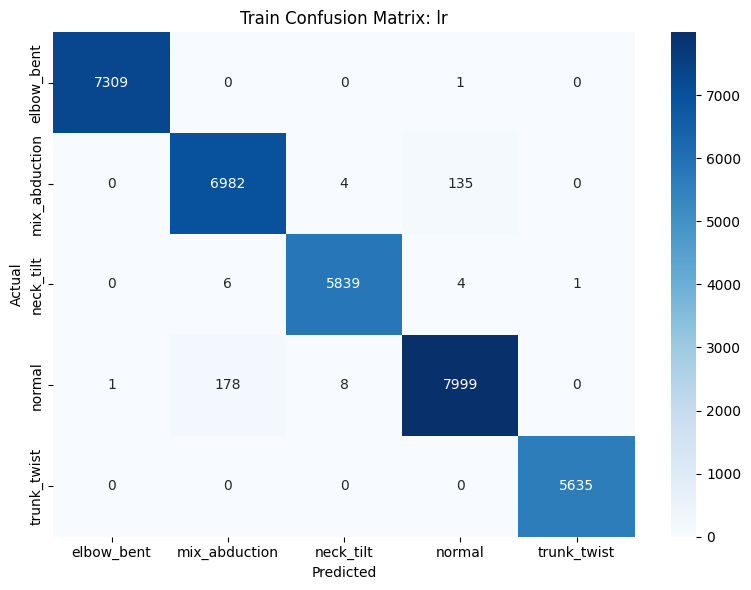

✅ Test Accuracy: 0.9169
               precision    recall  f1-score   support

   elbow_bent       0.97      0.98      0.97      1768
mix_abduction       1.00      0.94      0.97      1901
    neck_tilt       0.74      1.00      0.85      1617
       normal       0.94      0.88      0.91      2079
  trunk_twist       1.00      0.77      0.87      1360

     accuracy                           0.92      8725
    macro avg       0.93      0.91      0.91      8725
 weighted avg       0.93      0.92      0.92      8725



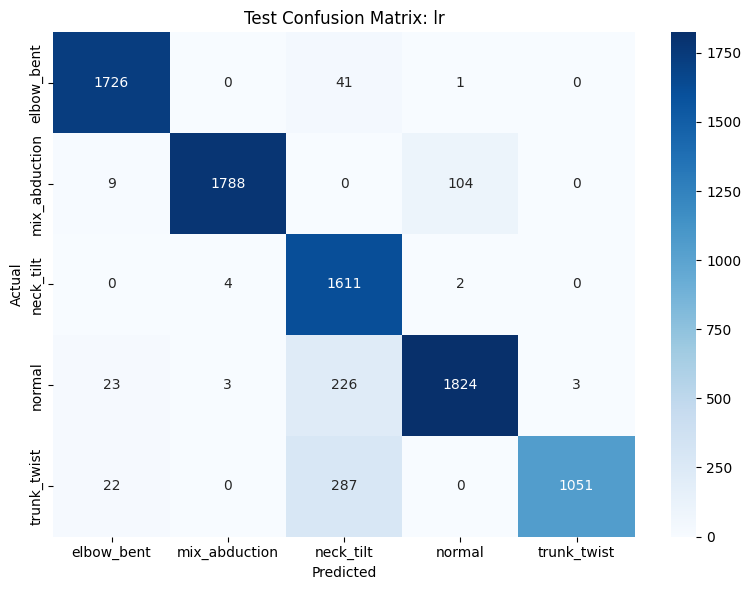

✅ Validation Accuracy: 0.2436
               precision    recall  f1-score   support

   elbow_bent       0.24      1.00      0.39      4058
mix_abduction       0.00      0.00      0.00      3659
    neck_tilt       0.00      0.00      0.00      3424
       normal       0.00      0.00      0.00      2599
  trunk_twist       0.87      0.04      0.07      3446

     accuracy                           0.24     17186
    macro avg       0.22      0.21      0.09     17186
 weighted avg       0.23      0.24      0.11     17186



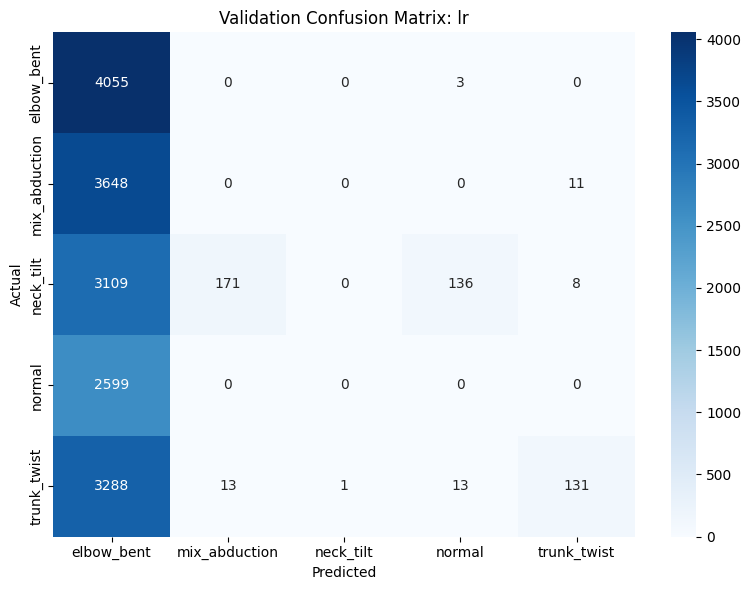


🔵 Training model: rc
✅ Train Accuracy: 0.9606
               precision    recall  f1-score   support

   elbow_bent       0.99      1.00      0.99      7310
mix_abduction       0.89      0.96      0.92      7121
    neck_tilt       0.98      0.99      0.99      5850
       normal       0.96      0.88      0.92      8186
  trunk_twist       1.00      1.00      1.00      5635

     accuracy                           0.96     34102
    macro avg       0.96      0.97      0.96     34102
 weighted avg       0.96      0.96      0.96     34102



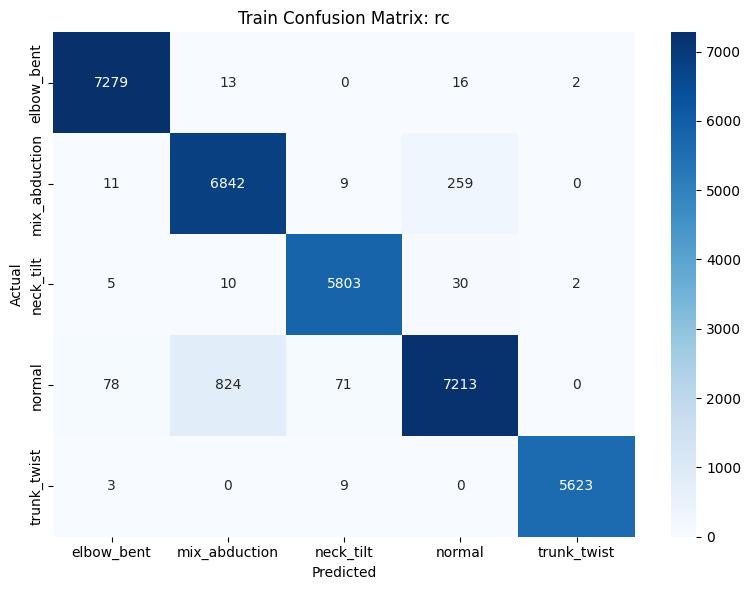

✅ Test Accuracy: 0.8958
               precision    recall  f1-score   support

   elbow_bent       0.94      0.99      0.96      1768
mix_abduction       0.97      0.79      0.87      1901
    neck_tilt       0.83      0.98      0.89      1617
       normal       0.82      0.91      0.86      2079
  trunk_twist       1.00      0.81      0.90      1360

     accuracy                           0.90      8725
    macro avg       0.91      0.89      0.90      8725
 weighted avg       0.91      0.90      0.90      8725



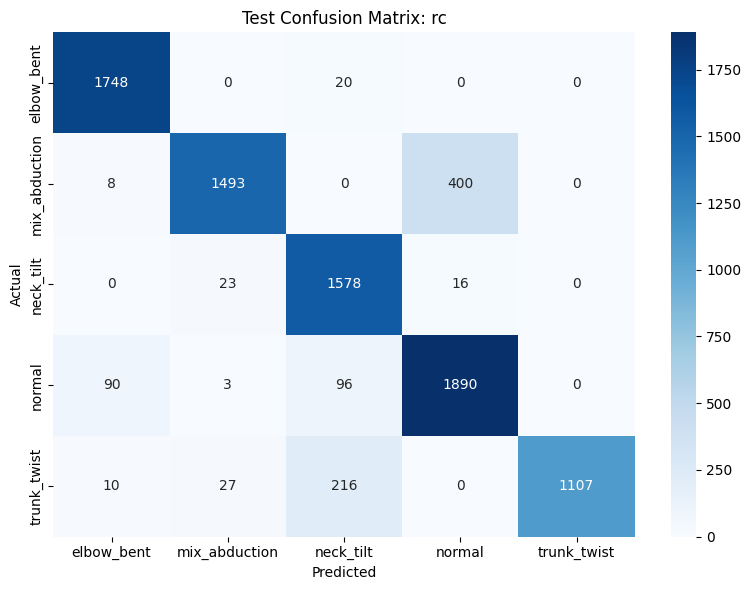

✅ Validation Accuracy: 0.3513
               precision    recall  f1-score   support

   elbow_bent       0.31      0.97      0.46      4058
mix_abduction       0.23      0.07      0.10      3659
    neck_tilt       1.00      0.00      0.00      3424
       normal       0.00      0.00      0.00      2599
  trunk_twist       0.58      0.54      0.56      3446

     accuracy                           0.35     17186
    macro avg       0.42      0.32      0.23     17186
 weighted avg       0.44      0.35      0.24     17186



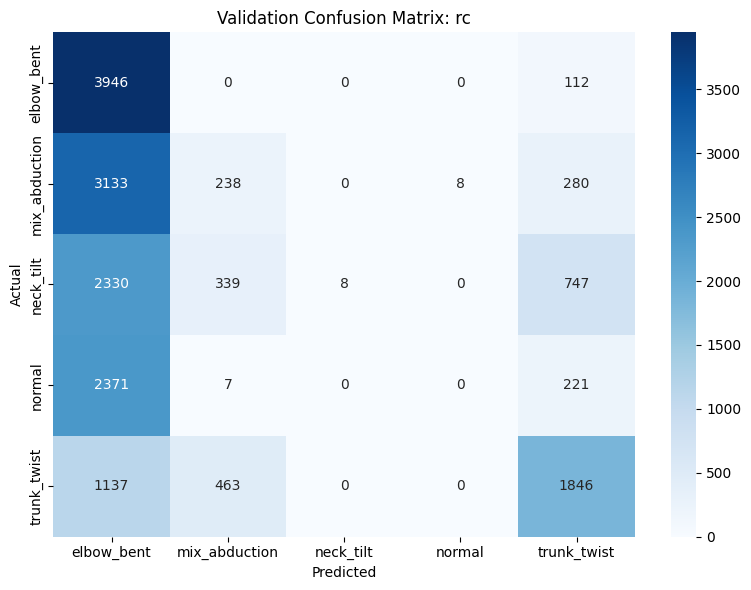


🔵 Training model: rf
✅ Train Accuracy: 1.0000
               precision    recall  f1-score   support

   elbow_bent       1.00      1.00      1.00      7310
mix_abduction       1.00      1.00      1.00      7121
    neck_tilt       1.00      1.00      1.00      5850
       normal       1.00      1.00      1.00      8186
  trunk_twist       1.00      1.00      1.00      5635

     accuracy                           1.00     34102
    macro avg       1.00      1.00      1.00     34102
 weighted avg       1.00      1.00      1.00     34102



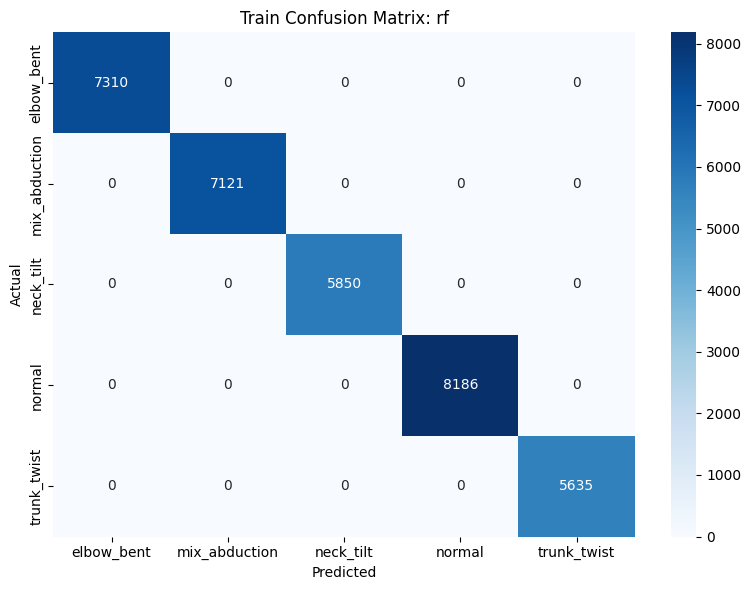

✅ Test Accuracy: 0.9462
               precision    recall  f1-score   support

   elbow_bent       1.00      0.98      0.99      1768
mix_abduction       0.99      0.92      0.95      1901
    neck_tilt       0.86      0.98      0.92      1617
       normal       0.91      0.96      0.94      2079
  trunk_twist       1.00      0.87      0.93      1360

     accuracy                           0.95      8725
    macro avg       0.95      0.94      0.95      8725
 weighted avg       0.95      0.95      0.95      8725



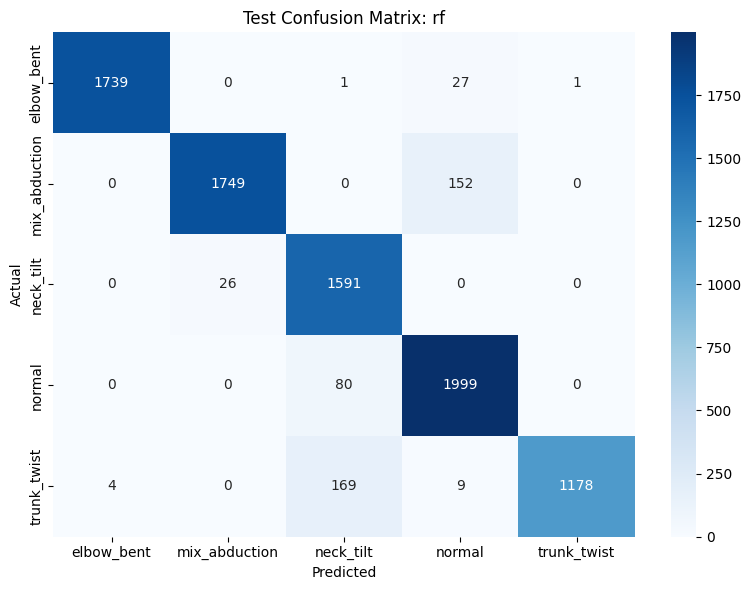

✅ Validation Accuracy: 0.4388
               precision    recall  f1-score   support

   elbow_bent       0.39      0.57      0.46      4058
mix_abduction       0.79      0.01      0.02      3659
    neck_tilt       0.97      0.45      0.61      3424
       normal       0.46      0.23      0.31      2599
  trunk_twist       0.37      0.89      0.52      3446

     accuracy                           0.44     17186
    macro avg       0.60      0.43      0.38     17186
 weighted avg       0.60      0.44      0.39     17186



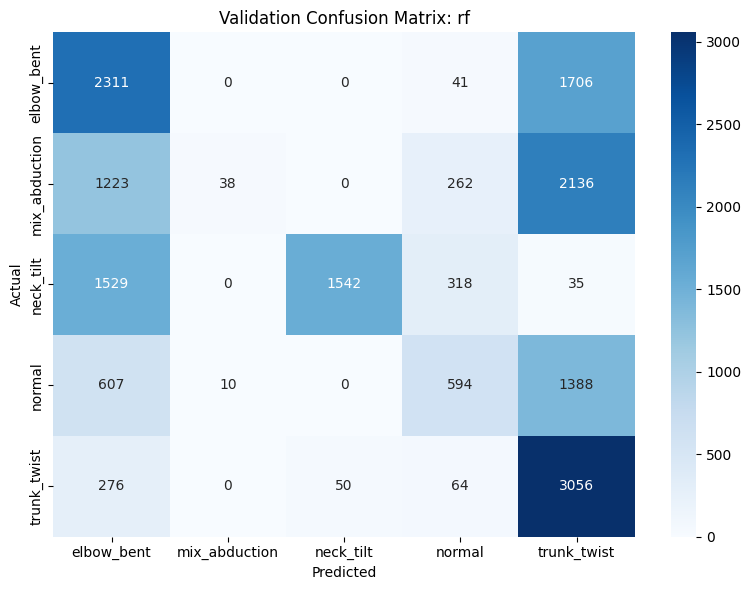


🔵 Training model: gb
✅ Train Accuracy: 0.9981
               precision    recall  f1-score   support

   elbow_bent       1.00      1.00      1.00      7310
mix_abduction       1.00      0.99      1.00      7121
    neck_tilt       1.00      1.00      1.00      5850
       normal       1.00      1.00      1.00      8186
  trunk_twist       1.00      1.00      1.00      5635

     accuracy                           1.00     34102
    macro avg       1.00      1.00      1.00     34102
 weighted avg       1.00      1.00      1.00     34102



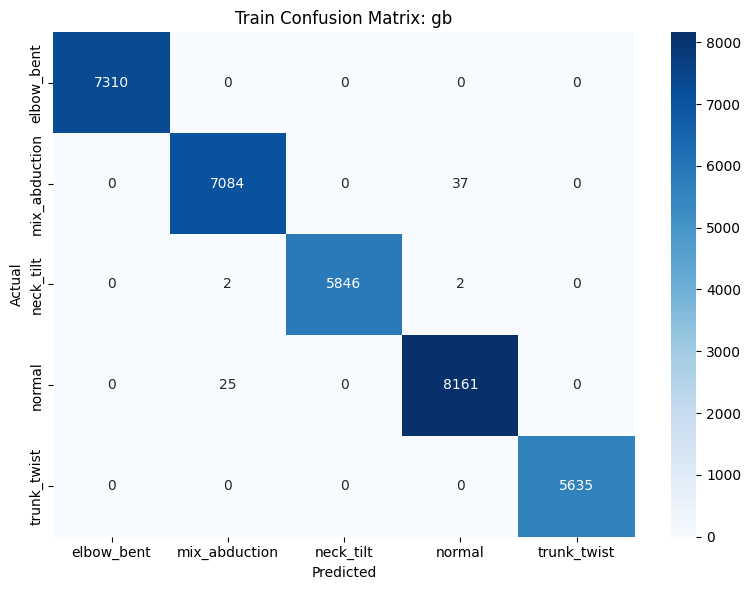

✅ Test Accuracy: 0.9625
               precision    recall  f1-score   support

   elbow_bent       1.00      1.00      1.00      1768
mix_abduction       0.97      0.91      0.94      1901
    neck_tilt       0.95      0.97      0.96      1617
       normal       0.92      0.96      0.94      2079
  trunk_twist       1.00      0.99      1.00      1360

     accuracy                           0.96      8725
    macro avg       0.97      0.96      0.97      8725
 weighted avg       0.96      0.96      0.96      8725



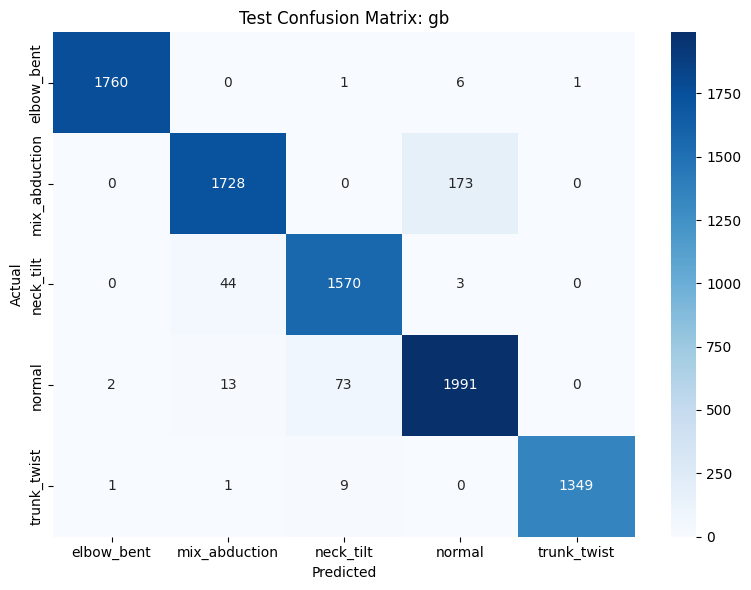

✅ Validation Accuracy: 0.2603
               precision    recall  f1-score   support

   elbow_bent       0.24      0.82      0.37      4058
mix_abduction       0.17      0.01      0.01      3659
    neck_tilt       1.00      0.04      0.07      3424
       normal       0.03      0.01      0.01      2599
  trunk_twist       0.41      0.29      0.34      3446

     accuracy                           0.26     17186
    macro avg       0.37      0.23      0.16     17186
 weighted avg       0.38      0.26      0.17     17186



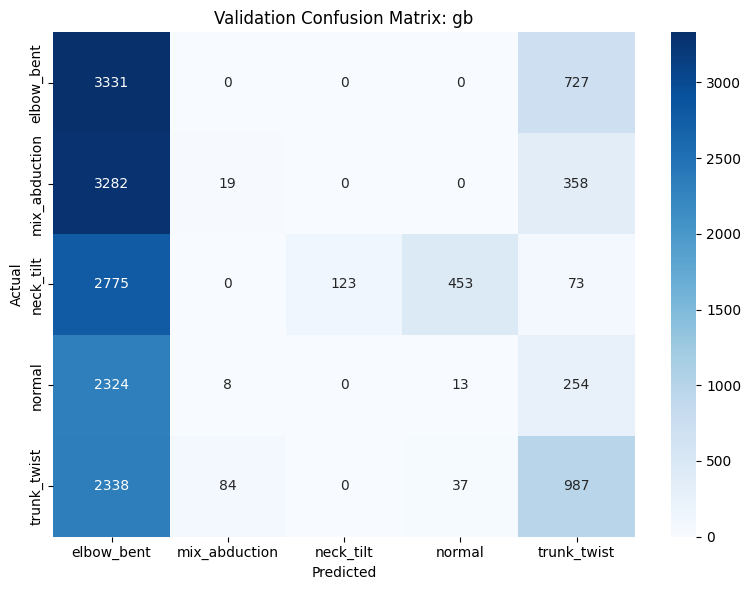

In [88]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# --- Split features & labels ---
def prepare_xy(df):
    X = df.drop(columns=['class_name', 'video_id', 'frame_num'])
    y = df['class_name']
    return X, y

X_train, y_train = prepare_xy(feature_filtered_train_df)
X_test, y_test = prepare_xy(feature_filtered_test_df)
X_validate, y_validate = prepare_xy(feature_filtered_validate_df)

# --- Define Model Pipelines ---
pipelines = {
    'lr': make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    'rc': make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb': make_pipeline(StandardScaler(), GradientBoostingClassifier()),
}

# --- Train + Evaluate All Sets ---
fit_models = {}
for name, model in pipelines.items():
    print(f"\n🔵 Training model: {name}")
    model.fit(X_train, y_train)
    fit_models[name] = model

    for split_name, X, y in [
        ('Train', X_train, y_train),
        ('Test', X_test, y_test),
        ('Validation', X_validate, y_validate),
    ]:
        y_pred = model.predict(X)
        acc = accuracy_score(y, y_pred)
        print(f"✅ {split_name} Accuracy: {acc:.4f}")
        print(classification_report(y, y_pred))

        # --- Confusion Matrix ---
        labels = np.unique(y)
        cm = confusion_matrix(y, y_pred, labels=labels)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels)
        plt.title(f'{split_name} Confusion Matrix: {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()


In [83]:
import pickle
with open('movemate_feature_rf.pkl', 'wb') as f:
    pickle.dump(fit_models['rf'], f)

In [89]:
feature_filtered_validate_df[feature_filtered_validate_df['class_name'] == 'normal'].head(100)

,class_name,video_id,frame_num,left_wrist_x,left_wrist_y,left_wrist_z,left_wrist_visibility,left_elbow_x,left_elbow_y,left_elbow_z,...,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_visibility,dist_shoulder_elbow,dist_elbow_wrist,dist_shoulder_hip,angle_elbow,angle_torso,angle_shoulder
57414,normal,1,52,0.632238,0.265969,-0.323798,0.978497,0.560175,0.463865,-0.329553,...,0.508213,0.725431,-0.202573,0.991165,0.266678,0.210609,0.283903,171.226991,131.764764,102.563439
57415,normal,1,53,0.640574,0.289500,-0.316614,0.978392,0.564109,0.478664,-0.329317,...,0.507930,0.728306,-0.202635,0.989818,0.255885,0.204034,0.284945,170.672810,130.157453,103.414214
57416,normal,1,54,0.653843,0.299184,-0.314350,0.978791,0.573518,0.484548,-0.328173,...,0.509376,0.728261,-0.202351,0.989359,0.252012,0.202020,0.286728,171.316365,129.136240,105.459242
57417,normal,1,55,0.664091,0.316221,-0.305140,0.978723,0.580849,0.500697,-0.319492,...,0.511121,0.731146,-0.192359,0.988880,0.240768,0.202388,0.289688,172.547985,127.944734,106.871961
57418,normal,1,56,0.675512,0.335720,-0.301119,0.977648,0.588317,0.513491,-0.318057,...,0.510892,0.732829,-0.193948,0.988473,0.232602,0.198005,0.291808,173.315258,126.845902,109.102489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57509,normal,1,53,0.640574,0.289500,-0.316614,0.978392,0.564109,0.478664,-0.329317,...,0.507930,0.728306,-0.202635,0.989818,0.255885,0.204034,0.284945,170.672810,130.157453,103.414214
57510,normal,1,54,0.653843,0.299184,-0.314350,0.978791,0.573518,0.484548,-0.328173,...,0.509376,0.728261,-0.202351,0.989359,0.252012,0.202020,0.286728,171.316365,129.136240,105.459242
57511,normal,1,55,0.664091,0.316221,-0.305140,0.978723,0.580849,0.500697,-0.319492,...,0.511121,0.731146,-0.192359,0.988880,0.240768,0.202388,0.289688,172.547985,127.944734,106.871961
57512,normal,1,56,0.675512,0.335720,-0.301119,0.977648,0.588317,0.513491,-0.318057,...,0.510892,0.732829,-0.193948,0.988473,0.232602,0.198005,0.291808,173.315258,126.845902,109.102489
